# Project -- Analysing IRA tweets --

In [129]:
import warnings # comment if you want to get the warnings from Searborn... 
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import re
import string
import datetime
import matplotlib.pyplot as plt
import findspark
import nltk
import nltk.classify.util
from nltk.corpus import names
from urllib.parse import urlparse
import requests
import os, requests, uuid, json
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import findspark
findspark.init()

from pyspark import SparkContext

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import StringType,BooleanType
from pyspark.mllib.stat import Statistics
from pyspark.sql.functions import explode
from pyspark.sql.functions import col, when, length

%matplotlib inline

spark = SparkSession.builder.getOrCreate()

In [85]:
# set up data directory
DATA_DIR = 'data/'

There are two main parts in this *Jupyter Notebook* :

* 1) **GETTING TO KNOW OUR MAIN DATASETS**. We intend to understand what contain our datasets (features and their dtypes) and to clean them in order to be ready for interpretation. We also may want to split or create new sub-datasets if there are interesting opportunities to do so.


* 2) **CONCRETE ANALYSIS**.  We summarized the most important findings since the beginning of the project in a data story like notebook. 

## 1. GETTING TO KNOW OUR MAIN DATASETS

### loading the data

In [3]:
# taking IRAN tweets into account or not 
include_iran = False

In [4]:
# load datasets thanks to Spark CSV reader 

if include_iran:
    
    # combine both RUS and IRAN datasets
    include_description = 'RUS & IRAN'
    
    tweets_text_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'*_troll_tweet_text.csv')
    tweets_stats_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'*_troll_tweet_stats.csv')
    tweets_meta_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'*_troll_tweet_metadata.csv')
    tweets_user_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'*_troll_user.csv')

else:
    
    # take only RUS datasets
    include_description = 'RUS'
    
    tweets_text_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'rus_troll_tweet_text.csv')
    tweets_stats_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'rus_troll_tweet_stats.csv')
    tweets_meta_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'rus_troll_tweet_metadata.csv')
    tweets_user_df = spark.read.format("csv").option("header", "true").load(DATA_DIR+'rus_troll_user.csv')

In [5]:
# look at the raw global datasets' sizes 

# n : number of observations
n_text = tweets_text_df.count()
n_stats = tweets_stats_df.count()
n_metadata = tweets_meta_df.count()
n_users = tweets_user_df.count()

# d : dimensionality of the data 
d_text = len(tweets_text_df.columns)
d_stats = len(tweets_stats_df.columns)
d_metadata = len(tweets_meta_df.columns)
d_users =  len(tweets_user_df.columns)

# print the results 
print(' Sizes of the datasets : ('+include_description+')')
print(' --------------------------------------------------------')
print('size of troll_tweet_text : '+str((n_text,d_text)))
print('size of troll_tweet_stats : '+str((n_stats,d_stats)))
print('size of troll_tweet_metadata : '+str((n_metadata,d_metadata)))
print('size of troll_user : '+str((n_users,d_users)))

 Sizes of the datasets : (RUS)
 --------------------------------------------------------
size of troll_tweet_text : (9041308, 3)
size of troll_tweet_stats : (9041308, 17)
size of troll_tweet_metadata : (9041308, 6)
size of troll_user : (3667, 11)


Roughly more than 9M tweets are available from RUS datasets (10M when combining both RUS AND IRAN). If after the cleaning there remains such a large number of data points, it's most likely that our statistical tests will present some significance if there are really underlying correlations, differences ... etc. 

We can assume, since the number of records for each dataframe is the same and because of the '*a priori*' description of the data, that the rows are ordered in such a way that every tuple of index $i$ in '*troll_tweet_text*' corresponds to the observations at index $i$ for '*troll_tweet_stats*' and '*troll_tweet_metadata*'. 

### tweets_text

In [6]:
# what does tweets_text look like ? size, dtypes
print((n_text,d_text))
tweets_text_df.dtypes

(9041308, 3)


[('tweetid', 'string'), ('tweet_language', 'string'), ('tweet_text', 'string')]

In [7]:
# a quick view
tweets_text_df.show(10)

+------------------+--------------+--------------------+
|           tweetid|tweet_language|          tweet_text|
+------------------+--------------+--------------------+
|877919995476496385|            ru|"RT @ruopentwit: ...|
|492388766930444288|            ru|Серебром отколоко...|
|719455077589721089|            bg|@kpru С-300 в Ира...|
|536179342423105537|            ru|Предлагаю судить ...|
|841410788409630720|            bg|Предостережение а...|
|834365760776630272|            ru|Двойная утопия, и...|
|577490527299457024|            ru|RT @harkovnews: Н...|
|596522755379560448|            ru|RT @NovostiNsk: «...|
|567357519547207680|            en|As sun and cloud ...|
|665533117369876480|            ru|RT @vesti_news: Ш...|
+------------------+--------------+--------------------+
only showing top 10 rows



***Is there anything to clean at this stage (before playing/dealing with the data) ?*** 

Below are listed the interventions we needed to perform in order to clean the data :      

Unknown *tweet_language* can take both the value 'und', or null. We harmonize this column by setting all NaN to 'und'.

In [8]:
tweets_text_df = tweets_text_df.fillna('und',['tweet_language'])

### tweets_stats

In [9]:
# what does tweets_stats look like ? size, dtypes
print((n_stats,d_stats))
tweets_stats_df.dtypes

(9041308, 17)


[('tweetid', 'string'),
 ('userid', 'string'),
 ('tweet_time', 'string'),
 ('in_reply_to_tweetid', 'string'),
 ('in_reply_to_userid', 'string'),
 ('quoted_tweet_tweetid', 'string'),
 ('is_retweet', 'string'),
 ('retweet_userid', 'string'),
 ('retweet_tweetid', 'string'),
 ('quote_count', 'string'),
 ('reply_count', 'string'),
 ('like_count', 'string'),
 ('retweet_count', 'string'),
 ('hashtags', 'string'),
 ('urls', 'string'),
 ('user_mentions', 'string'),
 ('poll_choices', 'string')]

In [10]:
# (a view is not adapted in the current context)
# tweets_stats_df.show(10)

***Is there anything to clean at this stage (before playing/dealing with the data) ?*** 

Below are listed the interventions we needed to perform in order to clean the data :      

We first convert the *tweet_time* into Datetime for ease of use, and we cast some columns into integers. We also create a static sql view of the main dataframe on which we can apply our SQL queries.

In [11]:
# dtypes transformations : 
tweets_stats_df = tweets_stats_df.withColumn('tweet_time', to_timestamp(tweets_stats_df.tweet_time))
tweets_stats_df = tweets_stats_df.withColumn('quote_count', tweets_stats_df.quote_count.cast('int'))
tweets_stats_df = tweets_stats_df.withColumn('reply_count', tweets_stats_df.reply_count.cast('int'))
tweets_stats_df = tweets_stats_df.withColumn('like_count', tweets_stats_df.like_count.cast('int'))
tweets_stats_df = tweets_stats_df.withColumn('retweet_count', tweets_stats_df.retweet_count.cast('int'))

# create a temporary Spark SQL view
tweets_stats_df.createOrReplaceTempView("tweets_stats_sql")

Now we can start splitting the data into smaller dataframes and remove the useless columns for each of those:
* **retweets_df** contains all the posts that are retweets.
* **replies_df** contains all the posts that are replies to other tweets.
* **normal_tweets_df** contains all the other ('normal') posts.

**NB:** some tweets have a value for *in_reply_to_userid* while their *in_reply_to_tweetid* is null (however the inverse never happens). Those are either replies to deleted tweets, or mentions of other users that were treated as replies. We decided to consider them as normal tweets.

In [12]:
# RETWEETS
retweets_df = spark.sql("SELECT * FROM tweets_stats_sql WHERE is_retweet=True")

# to understand how we selected the columns to remove, uncomment the next two lines
# => unique values for the whole column (either null, True , 0 ...)
#for col in retweets_df:
    #retweets_df.select(col).distinct().show(10)

# drop certain features
retweets_df = retweets_df.drop('in_reply_to_tweetid', 'in_reply_to_userid', 'is_retweet',\
                               'quote_count', 'reply_count', 'like_count', 'retweet_count',\
                               'poll_choices')

# record the size of the created sub-dataset
n_retweets = retweets_df.count()
d_retweets = len(retweets_df.columns)

# print the results
print(' Size of the sub-dataset : ('+include_description+')')
print(' --------------------------------------------------------')
print('size of retweets : '+str((n_retweets,d_retweets)))


 Size of the sub-dataset : (RUS)
 --------------------------------------------------------
size of retweets : (3333184, 9)


In [13]:
# REPLIES
replies_df = spark.sql("SELECT * FROM tweets_stats_sql WHERE is_retweet=False AND in_reply_to_tweetid IS NOT NULL")

# to understand how we selected the columns to remove, uncomment the next two lines
# => unique values for the whole column (either null, True , 0 ...)
#for col in replies_df:
    #replies_df.select(col).distinct().show(10)

# record the size of the created sub-dataset
replies_df = replies_df.drop('retweet_tweetid', 'retweet_userid', 'is_retweet')

# record the size of the created sub-dataset
n_replies = replies_df.count()
d_replies = len(replies_df.columns)

# print the results
print(' Size of the sub-dataset : ('+include_description+')')
print(' --------------------------------------------------------')
print('size of replies : '+str((n_replies,d_replies)))

 Size of the sub-dataset : (RUS)
 --------------------------------------------------------
size of replies : (266208, 14)


In [14]:
# NORMAL
normal_tweets_df = spark.sql("SELECT * FROM tweets_stats_sql WHERE is_retweet=False AND in_reply_to_tweetid IS NULL")

# to understand how we selected the columns to remove, uncomment the next two lines
# => unique values for the whole column (either null, True , 0 ...)
#for col in normal_tweets_df:
    #normal_tweets_df.select(col).distinct().show(10)
    
# record the size of the created sub-dataset
normal_tweets_df = normal_tweets_df.drop('in_reply_to_tweetid', 'retweet_tweetid', 'retweet_userid', 'is_retweet')

# record the size of the created sub-dataset
n_normal = normal_tweets_df.count()
d_normal = len(normal_tweets_df.columns)

# print the results
print(' Size of the sub-dataset : ('+include_description+')')
print(' --------------------------------------------------------')
print('size of normal tweets : '+str((n_normal,d_normal)))

 Size of the sub-dataset : (RUS)
 --------------------------------------------------------
size of normal tweets : (5441916, 13)


We verify that the number of rows correspond and that we did not duplicate or remove any by accident.

In [15]:
print(str(n_stats)+' vs. '+str(n_retweets+n_normal+n_replies))

9041308 vs. 9041308


### tweets_meta

In [16]:
# what does tweets_stats look like ? size, dtypes
print((n_metadata,d_metadata))
tweets_meta_df.dtypes

(9041308, 6)


[('tweetid', 'string'),
 ('follower_count', 'string'),
 ('following_count', 'string'),
 ('latitude', 'string'),
 ('longitude', 'string'),
 ('tweet_client_name', 'string')]

In [17]:
# a quick view
tweets_meta_df.show(10)

+------------------+--------------+---------------+--------+---------+------------------+
|           tweetid|follower_count|following_count|latitude|longitude| tweet_client_name|
+------------------+--------------+---------------+--------+---------+------------------+
|849295393867399169|          4042|           1470|    null|     null|Twitter Web Client|
|567280957913587713|           272|            390|    null|     null|          iziaslav|
|493095247690612736|            89|            223|    null|     null|          vavilonX|
|493892174069903360|            89|            223|    null|     null|          vavilonX|
|512503798506721280|            89|            223|    null|     null|          vavilonX|
|499624206246871041|            89|            223|    null|     null|          vavilonX|
|491828568251707392|            89|            223|    null|     null|          vavilonX|
|493768356810731520|            89|            223|    null|     null|          vavilonX|
|502221368

***Is there anything to clean at this stage (before playing/dealing with the data) ?*** 

Below are listed the interventions we needed to perform in order to clean the data :      

Just as with the previous dataset, we cast some columns into integers and we also create a static sql view of the main dataframe on which we can apply our SQL queries.

In [18]:
# dtypes transformations : 
tweets_meta_df = tweets_meta_df.withColumn('follower_count', tweets_meta_df.follower_count.cast('int'))
tweets_meta_df = tweets_meta_df.withColumn('following_count', tweets_meta_df.following_count.cast('int'))

# NOTE : we do not cast lattitude/longitude columns into integers since we intend to drop both 
# columns (see below why).

# create a temporary Spark SQL view
tweets_meta_df.createOrReplaceTempView("tweets_meta_sql")

It appears that the number of rows with a non-null *latitude*/*longitude* combination is very small compared to the size of dataset (less than 0.05%). Furthermore, several of them are repeated and are probably faked by the troll agents. We thus consider it rather useless and prefer dropping it.

In [19]:
temp = spark.sql("SELECT * FROM tweets_meta_sql WHERE latitude IS NOT NULL")
print('total number of observations for this data set '+str(n_metadata))
print('number of non NULL lattitude records : '+str(temp.count())+ ' and among them '+str(temp.select('latitude', 'longitude').distinct().count())+' unique coordinates pairs')

# drop lattitude and longitude 
tweets_meta_df = tweets_meta_df.drop('latitude', 'longitude')
      
# override previous TempView
tweets_meta_df.createOrReplaceTempView("tweets_meta_sql")

total number of observations for this data set 9041308
number of non NULL lattitude records : 4779 and among them 2938 unique coordinates pairs


The main feature that we can use to split the data here is *tweet_client_name*. When we take a closer look to this column, we discover that there are more than 400 values registered. Many of them seem unidentifiable.

However, we can see that a good amount of tweets are sent through official Twitter applications:
* **Twitter Web Client** accounts for around one third of the tweets in the dataset.
* **TweetDeck**, which allows to manage multiple accounts simultaneously, handles around 7% of the tweets.
* **Twitter For Android** is also in the top 15 applications used for those tweets.

Most of the other tweets are generated through automated social media managers, such as **twitterfeed** (shut down in 2016), **dlvr.it**, or even **IFTTT**.

In [20]:
temp = spark.sql("SELECT tweet_client_name, COUNT(*) AS count FROM tweets_meta_sql GROUP BY tweet_client_name ORDER BY count DESC")
print('number of twitter clients : '+str(temp.count()))
temp.show(15)

number of twitter clients : 334
+-------------------+-------+
|  tweet_client_name|  count|
+-------------------+-------+
| Twitter Web Client|2576596|
|        twitterfeed|1472547|
|          TweetDeck| 612024|
|      newtwittersky| 393074|
|          bronislav| 308516|
|           iziaslav| 299963|
|              IFTTT| 291269|
|          rostislav| 289475|
|        generationπ| 285503|
|         Twibble.io| 268402|
|    Ohwee Messanger| 240051|
|NovaPress Publisher| 204583|
|Twitter for Android| 163227|
|Приложение для тебя| 159588|
|           vavilonX| 148744|
+-------------------+-------+
only showing top 15 rows



Let's have a look on Twitter clients of the kind : *Twitter ... for ....*.

In [21]:
temp = spark.sql("SELECT tweet_client_name, COUNT(*) AS count FROM tweets_meta_sql WHERE tweet_client_name LIKE '%Twitter%' GROUP BY tweet_client_name ORDER BY count DESC")
print('number of such typical twitter clients : '+str(temp.count()))
temp.show()

number of such typical twitter clients : 18
+--------------------+-------+
|   tweet_client_name|  count|
+--------------------+-------+
|  Twitter Web Client|2576596|
| Twitter for Android| 163227|
|  Twitter for iPhone|  56168|
|Twitter for Andro...|  22126|
|    Twitter for iPad|   4432|
|Twitter for  Android|   3642|
|        Twitter Lite|   2891|
|      Twitter Nation|    813|
|Twitter for Websites|    762|
|Twitter for Nokia...|    442|
|Twitter for Black...|     92|
| Twitter for Windows|     92|
|Twitter for Black...|     71|
|Twitterrific for iOS|     21|
|Twitter for Windo...|      9|
|         Twitter Ads|      6|
|Twitter Business ...|      2|
|Unfollow Tools fo...|      1|
+--------------------+-------+



In the end, seeing how messy this dataset is, and how few columns it has, we decided to not split it.

In [22]:
# update the dimensionality of this dataset after the drop of columns
d_metadata=  len(tweets_meta_df.columns)
print('size of troll_tweet_metadata : '+str((n_metadata,d_metadata)))

size of troll_tweet_metadata : (9041308, 4)


### tweets_user

In [23]:
# what does tweets_stats look like ? size, dtypes
print((n_users,d_users))
tweets_user_df.dtypes

(3667, 11)


[('userid', 'string'),
 ('user_display_name', 'string'),
 ('user_screen_name', 'string'),
 ('user_reported_location', 'string'),
 ('user_profile_description', 'string'),
 ('user_profile_url', 'string'),
 ('account_creation_date', 'string'),
 ('account_language', 'string'),
 ('follower_count', 'string'),
 ('following_count', 'string'),
 ('last_tweet_at', 'string')]

***Is there anything to clean at this stage (before playing/dealing with the data) ?*** 

Below are listed the interventions we needed to perform in order to clean the data :      

We first convert the dates and integers present in the dataframe. This also treats the wrong encodings in those columns (such as a language ('en') present in *last_tweet_at*.

In [24]:
# dtypes transformations : 
tweets_user_df = tweets_user_df.withColumn('account_creation_date', to_timestamp(tweets_user_df.account_creation_date))
tweets_user_df = tweets_user_df.withColumn('last_tweet_at', to_timestamp(tweets_user_df.last_tweet_at))
tweets_user_df = tweets_user_df.withColumn('follower_count', tweets_user_df.follower_count.cast('int'))
tweets_user_df = tweets_user_df.withColumn('following_count', tweets_user_df.following_count.cast('int'))

# create a temporary Spark SQL view
tweets_user_df.createOrReplaceTempView("tweets_user_sql")

There also appear to be some wrong encodings in *account_language*. All languages are represented by a two letters code (except for *en-gb* and *zh-cn*, which correspond respectively to British English and Mainland Chinese). But a very small number of rows contain a date or a text as language.

After looking further into that, we discovered that those accounts wrote tweets in many different languages. As it is impossible for us to determine which one is their preferred language, we decided to set those inconsistent values to *'und'*.

In [25]:
temp = spark.sql("SELECT userid, account_language FROM tweets_user_sql WHERE LENGTH(account_language)>5")
print("number of rows with inconsistent account_language: " + str(temp.count()))
temp.show()

number of rows with inconsistent account_language: 3
+--------------------+----------------+
|              userid|account_language|
+--------------------+----------------+
|02b81295dbf8951d1...|      2016-01-13|
|          1240007161|      2013-03-03|
|8e77873eecf19db8d...|      2017-03-21|
+--------------------+----------------+



Let's apply the transformations required by the last comments. 

In [26]:
# filter on the account_language feature
tweets_user_df = tweets_user_df.withColumn('account_language', when(length(col('account_language'))>5, 'und').otherwise(col('account_language')))

In [27]:
# create temporary Spark SQL view
tweets_user_df.createOrReplaceTempView("tweets_user_sql")

Let's check that there are no more 'inconsistent' rows w.r.t our standards.

In [28]:
print("number of rows with inconsistent account_language: " + str(spark.sql("SELECT userid, account_language FROM tweets_user_sql WHERE LENGTH(account_language)>5").count()))

number of rows with inconsistent account_language: 0


We then split this dataframe into two:
* **anonymized_user_df** contains all the users that are anonymized.
* **exposed_user_df** contains all the other users.

This allows us to drop two columns for the anonymized users (users that have a *userid* that's the same as their *user_display_name* and *user_screen_name* : [Google APIs : twitter election integrity](https://storage.googleapis.com/twitter-election-integrity/hashed/Twitter_Elections_Integrity_Datasets_hashed_README.txt)) , which are a majority.

In [29]:
anonymized_user_df = spark.sql("SELECT * FROM tweets_user_sql WHERE userid=user_display_name")
exposed_user_df = spark.sql("SELECT * FROM tweets_user_sql WHERE NOT userid=user_display_name")

# drop useless columns 
anonymized_user_df = anonymized_user_df.drop('user_display_name', 'user_screen_name')

# print results + check that there are only two outcomes possible for userid = user_display_name
print('number of records from dataset user : '+str(n_users))
print('wherein there are '+str(anonymized_user_df.count())+' anonymized accounts and '+\
      str(exposed_user_df.count())+' exposed accounts')

number of records from dataset user : 3667
wherein there are 3500 anonymized accounts and 167 exposed accounts


### Summary

We have generated 4 main dataframes from the data files: *tweets_text_df*, *tweets_stats_df*, *tweets_meta_df*, and *tweets_user_df*. We then cleaned the inconsistent values and split those dataframes into smaller ones when possible and useful. Our data is now organised as follows:

* **tweets_text_df**: all the contents from the tweets, with an indication of their language.
* **tweets_stats_df**: 
    * **retweets_df**: all the information about retweets.
    * **replies_df**: all the information about replies.
    * **normal_tweets_df**: all the information about the other tweets.
* **tweets_meta_df**: all the meta information corresponding to each tweets (minus the latitude/longitude).
* **tweets_user_df**:
    * **anonymized_user_df**: all the information about anonymized users.
    * **exposed_user_df**: all the information about users who are not anonymized.
    

Before digging into some statistics we would like to underline the fact we can handle the data in its current size with the use of Spark. Previous requests did not take that much time with Spark SQL and the fact that our dataset is well partionned among several sub-datasets (data chunks) of interest will prevent us to query on too large files ! If we request very intensive computations on the data that embed many and many accesses to these chunks we will either make use of *Parquet* files or we will ***persist()*** Spark dataframes to keep them on top of the memory.

## 2.  CONCRETE ANALYSIS

**SOURCE** : Tweets collected by : [about_twitter/elections-integrity](https://about.twitter.com/en_us/values/elections-integrity.html#data) 

**NOTE** : *Not all the tweets collected are trolls*. Actually all the tweets present in our database were sent by identified troll accounts (at least this is the assumption one has to make while working on this dataset) but for most of these latter they seem to have played the game cleverly. In order not to be spotted immediately as fake foreign accounts they did also manage to ressemble as any other american/russian account. Therefore there exist plenty of '*innocent*' and '*unrelated*' tweets were also written aside by troll accounts for them to pretend to be just normal.

**Main Spark SQL views**

In [30]:
# create temporary Spark SQL views of our data chunks :

# normal_tweets_df
normal_tweets_df.createOrReplaceTempView("normal_tweets_sql")

# tweets_text_df
tweets_text_df.createOrReplaceTempView("tweets_text_sql")

# tweets_meta_df
tweets_meta_df.createOrReplaceTempView("tweets_meta_sql")

# tweets_user_df
tweets_user_df.createOrReplaceTempView("tweets_user_sql")

### Temporal and Quantitative analysis

For this first part of the analysis , we work most of the time on *tweet_stats* dataset .

We'll also make use of data provided by the following websites : [realclearpolitics/polls](https://www.realclearpolitics.com/epolls/latest_polls/president/#), [wikipedia/campaign_timeline](https://en.wikipedia.org/wiki/Timeline_of_the_2016_United_States_presidential_election).

Let's first analyze trolls *Twitter*'s activity over time. At first we take into account all the *normal_tweets* before trying to filter out non directly politically related tweets (about *Clinton*, *Trump*, *elections*, ... etc) to observe whether the overall trend is preserved. 

In [31]:
# display columns and their dtypes of normal tweets 
print((n_normal,d_normal))
normal_tweets_df.dtypes

(5441916, 13)


[('tweetid', 'string'),
 ('userid', 'string'),
 ('tweet_time', 'timestamp'),
 ('in_reply_to_userid', 'string'),
 ('quoted_tweet_tweetid', 'string'),
 ('quote_count', 'int'),
 ('reply_count', 'int'),
 ('like_count', 'int'),
 ('retweet_count', 'int'),
 ('hashtags', 'string'),
 ('urls', 'string'),
 ('user_mentions', 'string'),
 ('poll_choices', 'string')]

Let's group *normal_tweets* by month without truncating any time window yet.

In [32]:
# group and count by month (and year)
normal_dates_query = """SELECT COUNT(tweetid) AS count, MAX(tweet_time) AS last_time
                        FROM normal_tweets_sql
                        GROUP BY YEAR(tweet_time),MONTH(tweet_time)
                        ORDER BY YEAR(tweet_time),MONTH(tweet_time) ASC
                     """
normal_dates_df = spark.sql(normal_dates_query)

# store as a Panda dataframe (very small, absolutely no problem with the memory)
normal_dates_pd = normal_dates_df.toPandas()

normal_dates_pd[100:]

,count,last_time
100,39036,2017-10-31 23:55:00
101,3719,2017-11-30 23:13:00
102,2427,2017-12-31 21:00:00
103,1924,2018-01-31 23:50:00
104,2205,2018-02-28 23:53:00
105,1956,2018-03-31 23:34:00
106,1505,2018-04-30 23:53:00
107,1554,2018-05-31 17:02:00
108,107,2018-06-21 14:32:00


We can already observe that for some months the database doesn't contain any '*normal tweet*' ! 
Nevertheless there's actually only one month missing (August 2009) since there are 109 records and thus 108 records after the inital one whereas there would have been 109 records after May 2009 if every month was mentionned in the dataframe until June 2018

In [33]:
# recover the date of the first normal_tweet identified
start_normal_date_query = """SELECT MIN(UNIX_TIMESTAMP(tweet_time)) FROM normal_tweets_sql"""

start_normal_date = spark.sql(start_normal_date_query)
start_normal_date = start_normal_date.head()[0] # access the value of the query 

print('first normal tweet date (unix_time stamp) : ' + str(start_normal_date))
print('first normal tweet date (human readable) : '+str(pd.to_datetime(start_normal_date,unit='s')))

first normal tweet date (unix_time stamp) : 1241877540
first normal tweet date (human readable) : 2009-05-09 13:59:00


That corresponds to a tweet back in 2009 (9th of may). Of course the US 2016 presidential campaign didn't begin so early. As the reader will see, there are actually multiple *periods* of activity characterized by low/medium and high volume of tweets. 

As argued above this tweet is probably one old tweet of a '***troll account wannabe***'.

After discarding previous explanations some researches brought us on [cnbc/origins_or_IRA_dataset](https://www.cnbc.com/2018/10/17/reuters-america-update-2-twitter-publishes-tweet-trove-from-russia-iran-campaigns.html) that confirms our presumptions : all the tweets coming from the identified troll farm have been collected and gathered into the newly made available datasets. 

Let's mark down in different visual colors the 4 distinctive periods of tweets activity.

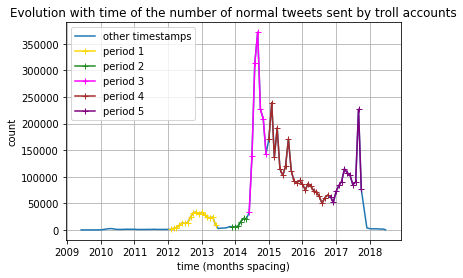

In [34]:
# plot purposes 

# period 1 

period_1_global_activity = normal_dates_pd[(normal_dates_pd['last_time']>datetime.datetime(2012,1,31)) & (normal_dates_pd['last_time']<=datetime.datetime(2013,6,30))]

# period 2 

period_2_global_activity = normal_dates_pd[(normal_dates_pd['last_time']>datetime.datetime(2013,11,30)) & (normal_dates_pd['last_time']<=datetime.datetime(2014,5,31))]

# period 3 

period_3_global_activity = normal_dates_pd[(normal_dates_pd['last_time']>datetime.datetime(2014,5,31)) & (normal_dates_pd['last_time']<=datetime.datetime(2014,12,31))]

# period 4

period_4_global_activity = normal_dates_pd[(normal_dates_pd['last_time']>datetime.datetime(2014,12,31)) & (normal_dates_pd['last_time']<=datetime.datetime(2016,10,31))]

# period 5 

period_5_global_activity = normal_dates_pd[(normal_dates_pd['last_time']>datetime.datetime(2016,10,31)) & (normal_dates_pd['last_time']<=datetime.datetime(2017,10,31))]


plt.figure(1)
plt.plot(normal_dates_pd['last_time'],normal_dates_pd['count'])
plt.plot(period_1_global_activity['last_time'],period_1_global_activity['count'],marker='+',color='gold')
plt.plot(period_2_global_activity['last_time'],period_2_global_activity['count'],marker='+',color='forestgreen')
plt.plot(period_3_global_activity['last_time'],period_3_global_activity['count'],marker='+',color='magenta')
plt.plot(period_4_global_activity['last_time'],period_4_global_activity['count'],marker='+',color='brown')
plt.plot(period_5_global_activity['last_time'],period_5_global_activity['count'],marker='+',color='purple')

plt.title('Evolution with time of the number of normal tweets sent by troll accounts')
plt.grid()
plt.xlabel('time (months spacing)')
plt.ylabel('count')
plt.legend(['other timestamps','period 1','period 2','period 3','period 4','period 5'],loc=2);

Let's have a look at the evolution with the time of the number of *troll* accounts registered.   

    last_time  nb_users
0         NaT         3
1  2009-04-24         1
2  2009-05-09         1
3  2009-09-08         1
4  2009-10-08        31
5  2009-11-05         1
6  2010-04-11         1
7  2010-09-11         2
8  2010-10-18         3
9  2011-04-21         1
10 2011-10-02         1
11 2011-11-17         2
12 2011-12-29         2
13 2012-01-23         5
14 2012-02-29        10
15 2012-03-24         9
16 2012-04-14         5
17 2012-07-24         2
18 2012-08-28        24
19 2012-09-09         1
20 2012-12-29         3
21 2013-01-25         2
22 2013-02-28         4
23 2013-03-04         3
24 2013-05-20         2
25 2013-06-28        43
26 2013-07-31        47
27 2013-08-31       503
28 2013-09-29        71
29 2013-10-23        45
..        ...       ...
51 2015-08-28         2
52 2015-09-30        35
53 2015-10-28        38
54 2015-11-28        28
55 2015-12-24        56
56 2016-01-28        13
57 2016-02-27        14
58 2016-03-29         7
59 2016-04-29        14
60 2016-05-30   

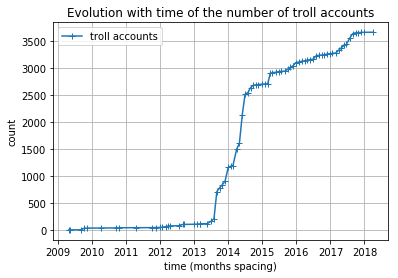

In [69]:
# group user accounts by time (month)
accounts_creation_dates_query = """SELECT MAX(account_creation_date) as last_time, COUNT(userid) as nb_users
                                    FROM tweets_user_sql
                                    GROUP BY YEAR(account_creation_date),MONTH(account_creation_date)
                                    ORDER BY YEAR(account_creation_date),MONTH(account_creation_date) ASC
                                """

accounts_creation_dates_df = spark.sql(accounts_creation_dates_query)

# small enough dataframe : it holds conveniently into Pandas for further plotting
accounts_creation_dates_pd = accounts_creation_dates_df.toPandas()
print(accounts_creation_dates_pd)
# a cumulative sum with time is required to show the evolution of the number of troll accounts
accounts_creation_dates_pd = accounts_creation_dates_pd.dropna()
accounts_creation_dates_pd.nb_users = accounts_creation_dates_pd.nb_users.cumsum()

plt.figure(1)
plt.plot(accounts_creation_dates_pd['last_time'],accounts_creation_dates_pd['nb_users'],marker='+')
plt.title('Evolution with time of the number of troll accounts')
plt.grid()
plt.xlabel('time (months spacing)')
plt.ylabel('count')
plt.legend(['troll accounts'],loc=2);

Here we give a first insight on each period and its meaning. More detailed analysis will be conducted for each period in the dedicated sections of this notebook.

**period 1 (US 2012 Elections)**

A first increasing trend is observed around 40 months after May 2009. More precisely that small, yellow, hill is located in time from February 2012 to June 2013 (increase from $\simeq 3000$ *normal_tweets* per month in February 2012 to $\simeq 34000$ in October 2012 before falling back again, smoothly, to $\simeq 2500$ in June 2013). 

Actually, this periods totally corresponds to the previous US presidential campaign for which Barack Obama had been elected president of the United States of America for the second time in a row. The observable peak of activity (October 2012) falls in the month prior to 2012's final elections. 

Taking a look at the graph showing the evolution of the number of troll accounts with time one can argue that for such a small amount of them during period 1 they had to be quite active for that campaign.  

**period 2 (Hiring Time)**

Starting from $\simeq$ mid-2013 and mostly at the beginning of 2014 one can notice a sudden increase in both the number of accounts and the troll feed activity ; those latter being obviously correlated. Looking at [wikipedia/IRA's page](https://en.wikipedia.org/wiki/Internet_Research_Agency) one can underline the job offer proposed in August 2013 : 

                                                "Internet operators wanted! ..."
                                                
The following website shed light on the early practices of IRA [wired.co.uk/twitter-trolls](https://www.wired.co.uk/article/twitter-troll-data-russia-ira-iran) Actually the initial goal of the "*agency*" was to infere on several events of the actuality (Elections, War in Ukraine, Terrorism, ... $\rightarrow$ massive opportunities). Below the reader will find multiple signs/pieces of evidence of the diversity of the actions lead by IRA's troll farm.

**period 3 (War in Donbass in full swing !)**

This time window corresponds to a massive tweet campaign of IRA to support pro-russian factions in *Donbass' war* in Ukrainia.

**period 4 (US 2016 Elections)**

(Note Ukraine's war is still undergoing at that time). 

We observe a peak starting after 61 months from May 2009, thus in June 2014. This corresponds exactly to one year prior the moment when Donald Trump announced his candidacy for the primaries (republican) [wikipedia/donald_trump](https://en.wikipedia.org/wiki/Donald_Trump#Political_activities_up_to_2015). 

This period of ***high*** activity embeds both Ukraine's war (2014-present, but its itensity reached a peak in mid-2014) and US 2016 presidential elections. 

After the peak the *troll* fever seems to drop monotically until June 2016 before growing up again **right before the final US elections** of november 2016. 

**period 5 (Ukraine's war & Presidential Instability)**

Right after the elections the activity of troll accounts isn't decreasing yet. Many contestations of the election results, transition of presidency ... etc make good troll topics. One could observe that until the end ofJanuary 2017, Trump's election wasn't confirmed yet by the congress [wikipedia/header](https://en.wikipedia.org/wiki/Timeline_of_the_2016_United_States_presidential_election)

Trollers stop after 100 months, at the beginning of the academic year 2017-2018 (end of October 2017).

----------------------------------------------------------------------------------------------------------------------------

### Textual analysis
In order to answer to the questions 3 and 4 we must interest ourselves in the text of the tweets itself.



First let us only work, with the **normal** tweets, i.e. the tweets that are nor retweets and nor responses.

In [124]:
tweets_text_df.createOrReplaceTempView("tweets_text_sql") # Create temporary view to perform SQL operations
normal_tweets_df.createOrReplaceTempView("normal_tweets_sql")
join_query = """SELECT tweets_text_sql.tweetid, tweet_language, tweet_text FROM tweets_text_sql JOIN normal_tweets_sql ON normal_tweets_sql.tweetid = tweets_text_sql.tweetid"""

normal_tweets_text_df = spark.sql(join_query)
normal_tweets_text_df.show()

+-------------------+--------------+--------------------+
|            tweetid|tweet_language|          tweet_text|
+-------------------+--------------+--------------------+
|1000381306088419334|            ru|"«Похоже, президе...|
|1001787839292600321|            ru|Доброго всем дня ...|
|1008658294003683330|            ru|Редиска - нехорош...|
|1008728801516322817|            ru|Пресс-секретарь В...|
|1009712567772700672|            ru|Поскорей бы пенси...|
|        10187620937|           und|Звучат фанфары,бъ...|
| 102454331449675776|           und|Почему в России б...|
|  10383282331979776|           und|Так толкается тол...|
|        10581173482|           und|    Кровельная месть|
|        10798638464|           und|Чешские женщины в...|
| 109033085814837248|           und|Чаще всего люди н...|
|        11047319023|           und|Зеркальные зеркал...|
| 110726396875247616|           und|Сказал эстонцам, ...|
|        11122632790|           und|Не героин её Рома...|
|        11260

**Languages**

The first natural step is to identify the different languages present in our database. Let's group the tweets by languages and see which languages we will have to deal with.

+--------------+--------------+
|tweet_language|language_count|
+--------------+--------------+
|            ru|       2711826|
|            en|       2109062|
|           und|        381145|
|            de|         83362|
|            uk|         47910|
|            bg|         34235|
|            ar|         18647|
|            es|          7454|
|            fr|          6584|
|            sr|          5233|
|            in|          4862|
|            tl|          3349|
|            et|          2913|
|            ht|          2374|
|            da|          2259|
|            tr|          2229|
|            ro|          2144|
|            it|          1831|
|            nl|          1821|
|            pt|          1519|
+--------------+--------------+



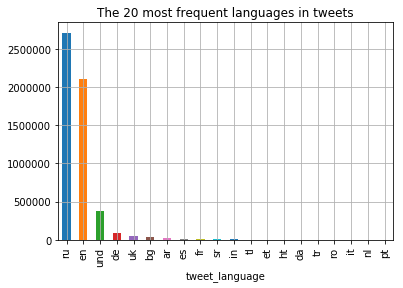

In [125]:
normal_tweets_text_df.createOrReplaceTempView("tweets_text_sql") # Create temporary view to perform SQL operations

query_language = """WITH lang_counts AS (SELECT tweet_language, COUNT(tweet_language) AS language_count FROM tweets_text_sql GROUP BY tweet_language)
SELECT * FROM lang_counts ORDER BY language_count DESC LIMIT 20"""

language_count_df = spark.sql(query_language)

language_count_df.show()

# We can then draw a bar plot
language_count_df.toPandas().plot.bar(x = "tweet_language", y = "language_count",legend=False, 
                                      title="The 20 most frequent languages in tweets",grid=True)

We can see that there are a big variety of languages but the two big winners are the 'english' and the 'russian'. We will focus on those two for the moment. The und stands for 'undefined'. This can be explained by the facts that Tweets are written in a poor grammatical structure, making them difficult to understand by a computer. 

We now have to identify the main subjects discussed in each tweet. Unfortunately none of us can speak russian, we nevetherless can translate these tweets by sending a HTTP request to bing-translate (Note that the translation is far from being perfect but at least we will have a global idea of what the tweets talk about).

First let us first restrict ourselves to the english and russian tweets

In [126]:
df_ru = spark.sql("""SELECT * FROM tweets_text_sql WHERE tweet_language = 'ru'""")
df_en = spark.sql("""SELECT * FROM tweets_text_sql WHERE tweet_language = 'en'""")
df_ru.show()
df_en.show()

+-------------------+--------------+--------------------+
|            tweetid|tweet_language|          tweet_text|
+-------------------+--------------+--------------------+
|1000381306088419334|            ru|"«Похоже, президе...|
|1001787839292600321|            ru|Доброго всем дня ...|
|1008658294003683330|            ru|Редиска - нехорош...|
|1008728801516322817|            ru|Пресс-секретарь В...|
|1009712567772700672|            ru|Поскорей бы пенси...|
| 128276771949903872|            ru|Ходят люди с теле...|
| 159432973853274112|            ru|не в монобровь та...|
| 165041529080131586|            ru|RT @xenia_sobchak...|
| 189598271797338113|            ru|Басков обещал жен...|
| 189631262082859009|            ru|@b059c98801ff3305...|
| 189690305681960960|            ru|ты почитай, что о...|
| 214444610532028416|            ru|RT @De_Agosto: Го...|
| 245981687689924608|            ru|RT @Della_Street_...|
| 249807536788733955|            ru|RT @andrei_izosim...|
| 254852097940

Now let us translate the russian tweets into english. Translating all the tweets would be too expensive in time and money. Let us thus focus on the 15.000 most important ones i.e. the 15.000 tweets with the highest retweet_count value.

In [32]:
df_ru.createOrReplaceTempView("df_ru_sql") # Create temporary view to perform SQL operations
# select 15000 most important tweets
importance_query = """WITH retweet AS (SELECT tweetid AS tweetid2, retweet_count FROM tweets_stats_sql ORDER BY retweet_count DESC LIMIT(15000))
SELECT tweetid, tweet_text FROM df_ru_sql JOIN retweet ON retweet.tweetid2 = df_ru_sql.tweetid"""
df_ru_sampled = spark.sql(importance_query)
df_ru_sampled.show()

+------------------+--------------------+
|           tweetid|          tweet_text|
+------------------+--------------------+
|818056880568365056|И то правда... ht...|
|779379418607325184|Белорусских парал...|
|808298986847272961|Фарион рассказыва...|
|732564713481986048|Сложный выбор: и ...|
|915857888098357249|Товарищи! Как вы ...|
|714734768156442624|ГЕРОЙ, ВЫЗВАВШИЙ ...|
|742691056223944704|Сборная России ус...|
|848611782893723649|Но тиран всё равн...|
|773794159043964928|Поддержите акцию ...|
|881544665710960641|В центре Киева ра...|
|836581455224504320|Всё, в ДНР начала...|
|873841280719171585|Прекрасное видео ...|
|718740064067534849|ШЕСТИМЕСЯЧНАЯ БЕС...|
|788749331440558081|В Киеве скажут, ч...|
|680652024258531328|Казарма ВСУ. И ве...|
|848924715330797570|Шмарам методички ...|
|751071804068769792|Хакер, взломавший...|
|731160274426843137|Время напомнить в...|
|802566128585375744|Бюст Сталина в Ли...|
|796271890398593024|Против Трампа был...|
+------------------+--------------

Let us define a function that sends HTTP request to the bin server (here we put subscriptionKey = 'xxx' ) because it is private information.

In [46]:
def translator(sentence, from_lang = 'ru', to_lang = 'en'):
    subscriptionKey = 'xxx'
    base_url = 'https://api.cognitive.microsofttranslator.com'
    path = '/translate?api-version=3.0'
    params = '&from=ru&to=en'
    constructed_url = base_url + path + params

    headers = {
        'Ocp-Apim-Subscription-Key': subscriptionKey,
        'Content-type': 'application/json',
        'X-ClientTraceId': str(uuid.uuid4())
    }

    body = [{
        'text' : sentence
    }]
    request = requests.post(constructed_url, headers=headers, json=body)
    response = request.json()

    return response[0]['translations'][0]['text']

Translate the tweets and save them to parquet.

In [43]:
df_ru_translated = df_ru_sampled.rdd.map(lambda r: (r[0],translator(r[1]))) # Translate the tweets
spark_df_ru_translated = spark.createDataFrame(df_ru_translated,['tweedid', 'tweet_text'])
spark_df_ru_translated.write.mode('overwrite').parquet("translated_tweets")

Here is what the translated tweets look like

In [27]:
translated_ru = spark.read.parquet("translated_tweets")
translated_ru.show()

+------------------+--------------------+
|           tweedid|          tweet_text|
+------------------+--------------------+
|888352384812019712|Marin Le Pen: We ...|
|883700663208824832|Elena Prikhodko, ...|
|838736168640466944|Is Litvinova okay...|
|696384621601300480|Ahahaha HTTPS://T...|
|884345115363487744|On July 10, 2016 ...|
|747049705104891904|"Bobyon is" the "...|
|870263243431964672|"Vanichka Nesteru...|
|781441079564468224|39-year-old resid...|
|704991386874019840|Northern Venice ?...|
|734372506300256256|Kiev was going to...|
|660440831283888128|All those who tod...|
|757853549615124481|Pushkov called Ru...|
|805075503329722368|URGENT NEWS! Syri...|
|502409560368623617|"Putin saw his ra...|
|760002770246197248|The Islamic State...|
|676811008262995969|"This is the" Pin...|
|731819715589488640|"Ukrainian politi...|
|735736512113827840|174 persons. But ...|
|817744710928367616|The Permiaki went...|
|877911586949738498|On June 22, 1990 ...|
+------------------+--------------

**Hashtags**

Another important aspect of the tweets are the hashtags. They represent a lot of information as they can tell about the subject of the tweet, the opinion of the tweeter, ...

Let us first interest ourselves in the english tweets

In [24]:
# Introduce a pattern to match into the form of a regexp
regexp = re.compile("\B#\w\w+",re.IGNORECASE)

# @goal : return all the matching expressions : i.e. '#word will be transformed to ['word']
def tag_split(text):
    return regexp.findall(text)

# Apply this first map in order to flatten expressions of the type #word1#word2 ... 
flattered_tweets = df_en.rdd.map(lambda r: (r[0],r[1],tag_split(r[2])))

# Going back to dataframes to enjoy the "explode" methods that does exactly what we need
tweets_new_df = spark.createDataFrame(flattered_tweets, ['tweetid','tweet_language','tweet_text'])

# Create another SQL view for questions with this new representation
tweets_new_df.withColumn('hashtag', explode(tweets_new_df.tweet_text)).createOrReplaceTempView("tweets_flat_sql")

+-----------------+---------+
|          hashtag|frequency|
+-----------------+---------+
|            #news|   228507|
|          #sports|    92168|
|        #politics|    72735|
|           #local|    49897|
|           #world|    28000|
|        #business|    25334|
|         #Chicago|    21515|
|          #health|    20619|
|            #love|    16511|
|         #TopNews|    15641|
|        #breaking|    15309|
|           #Texas|    11924|
|   #Fukushima2015|    11702|
|         #NewYork|    11168|
|            #Foke|    11090|
|            #true|    10926|
|         #showbiz|    10138|
|            #tech|    10130|
|  #FukushimaAgain|     9250|
|#BlackLivesMatter|     9250|
+-----------------+---------+



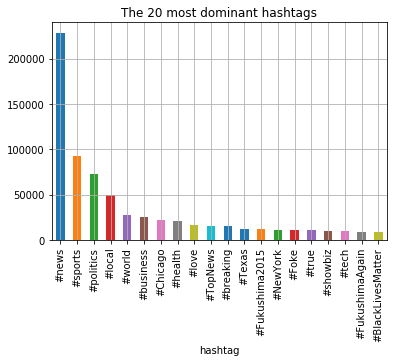

In [25]:
# Select the 20 most frequent hashtags
pre_query = """WITH hashtag_freq AS(SELECT hashtag, COUNT(tweetid) AS frequency FROM tweets_flat_sql GROUP BY hashtag)
SELECT * FROM hashtag_freq ORDER BY frequency DESC LIMIT(20)"""

hashtags_count_df = spark.sql(pre_query)
hashtags_count_df.show()

# Plot purposes
hashtags_count_df.toPandas().plot.bar(x = "hashtag", y = "frequency",legend=False, title="The 20 most dominant hashtags",grid=True)

As we can see the most used hashtags are those about news, sports and politics. This makes sense as these 3 topics are actively debated by all tweeter's users, trolls included

Now for the russian ones

In [28]:
# Apply this first map in order to flatten expressions of the type #word1#word2 ... 
flattered_tweets = translated_ru.rdd.map(lambda r: (r[0],tag_split(r[1])))

# Going back to dataframes to enjoy the "explode" methods that does exactly what we need
tweets_new_df = spark.createDataFrame(flattered_tweets, ['tweetid','tweet_text'])

# Create another SQL view for questions with this new representation
tweets_new_df.withColumn('hashtag', explode(tweets_new_df.tweet_text)).createOrReplaceTempView("tweets_flat_sql")

+--------------------+---------+
|             hashtag|frequency|
+--------------------+---------+
|                #ВСУ|       40|
|                #ДНР|       19|
|          #ПозорWADA|       10|
|      #АнгелыВсердце|        8|
|                #ЛНР|        7|
|      #БоженуКОтвету|        6|
|                 #RT|        5|
|   #ГивиВечнаяПамять|        5|
|     #АвгустВосьмого|        5|
|   #ПодвигЛенинграда|        5|
|            #Дети101|        4|
| #FreeGrahamPhillips|        4|
|      #StopMorganLie|        4|
|           #ЯНеШарли|        3|
|   #УмираюНоНеСдаюсь|        3|
|       #ПамятиБузины|        3|
|#ИспортиМеняДеньгами|        3|
|#СвободуМехтиЛогу...|        3|
|#ДеньВетеранаБоев...|        3|
|        #СлужуРоссии|        3|
+--------------------+---------+



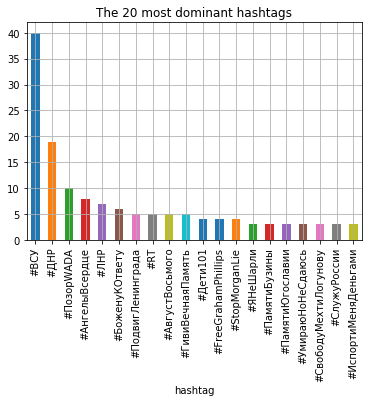

In [29]:
# Select the 20 most frequent hashtags
pre_query = """WITH hashtag_freq AS(SELECT hashtag, COUNT(tweetid) AS frequency FROM tweets_flat_sql GROUP BY hashtag)
SELECT * FROM hashtag_freq ORDER BY frequency DESC LIMIT(20)"""

hashtags_count_df = spark.sql(pre_query)
hashtags_count_df.show()

# Plot purposes
hashtags_count_df.toPandas().plot.bar(x = "hashtag", y = "frequency",legend=False, title="The 20 most dominant hashtags",grid=True)

The tweets are in a special structure that disallow them from translation. But googling the five dominant tweets teaches that
* ВСУ is the "Armed Forces of Ukraine"
* ДНР is Donetsk People's Republic which is a proto-state of Ukraine
* ПозорWADA which talks about the cancellation of the russian paralympic games
* АнгелыВсердце refers to the events of the killed children of dombass
* ЛНР means Luhansk People's Republic which is another proto-state of Ukraine

These 5 hashtags refer all to highly controversated events, which again makes sense for highly retweeted tweets.  

The comparison with the hashtags of non-troll users is made in our data story

**Words**

Now that we have analysed the hashtags, let us focus on the words themselves. This allows us to see what are the typical words used by trolls.

Note : we will remove the hashtags for this analysis

Let us first clean the tweets. Indeed a tweet contains a lot of noisy information i.e. links, RT, @somebody, #word, ...

Furthermore, a lot of variants of the same words exists. This is why we can use stemming to bring every word into its most reduced form.

Finally, every tweet contains stopwords i.e. words that we must use to build sentence but don't bring any particuliar information on the tweet itself (e.g. 'it', 'me', 'then', ...). These words can be removed to do some particuliar analysis.

In [36]:
'-' in stopwords

True

In [130]:
stemmer = nltk.SnowballStemmer("english", ignore_stopwords=True)  # Initialize stemmer that 'kills' also stopwords
# custom list of stopwords
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself',
             'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself',
             'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these',
             'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do',
             'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while',
             'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before',
             'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',
             'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each',
             'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than',
             'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', 'd', 'll', 'm', 'o', 're', 've',
             'y', 'ain', 'aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'ma', 'mightn', 'mustn',
             'needn', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn', 'make', 'go', 'get', "it's", 'us', '&amp;',
            'want', 'get', 'new', "don't", "i'm", 'one', 'say']

def tweet_cleaner(text, stem_option = True):
    """This function takes a String as input and returns a 'cleaned' version of it.
    -> No punctuation
    -> No links, hashtags, ...
    -> Stemming if stem_option = True"""
    text = re.sub(r'[.,"!,-;]+', '', text, flags=re.MULTILINE)  # removes the characters specified
    text = re.sub(r'^RT[\s]+', '', text, flags=re.MULTILINE)  # removes RT
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)  # remove link
    text = re.sub(r'[:]+', '', text, flags=re.MULTILINE)
    new_line = ''
    for i in text.split():  # remove stopwords and # words
        stemmed_word = stemmer.stem(i)
        if '#' not in stemmed_word and stemmed_word not in stopwords:
            
            new_line += stemmed_word + ' '
    return new_line

def tweet_cleaner_vader(text):
    """This function takes a String as input and returns a 'cleaned' version of it.
    -> No links, hashtags, no arobase"""
    text = re.sub(r'^RT[\s]+', '', text, flags=re.MULTILINE)  # removes RT
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)  # remove links
    text = re.sub(r'[:]+', '', text, flags=re.MULTILINE)
    new_line = ''
    for i in text.split():  # remove @ and # words
        if not i.startswith('@') and not i.startswith('#'):
            new_line += i + ' '
    return new_line

In [38]:
flattered_tweets = df_en.rdd.map(lambda r: (r[0],r[1],tweet_cleaner(r[2]).split()))

# Going back to dataframes to enjoy the "explode" methods that does exactly what we need
tweets_new_df = spark.createDataFrame(flattered_tweets, ['tweetid','tweet_language','tweet_text'])

# Create another SQL view for questions with this new representation
tweets_new_df.withColumn('words', explode(tweets_new_df.tweet_text)).createOrReplaceTempView("tweets_flat_sql")

+-------+---------+
|  words|frequency|
+-------+---------+
|  trump|   105092|
|    man|    70995|
|  polic|    57372|
|   like|    52234|
|   love|    48045|
|  peopl|    47948|
|  obama|    42264|
|workout|    41295|
|   kill|    40179|
|   time|    39757|
|    day|    36892|
|   look|    36034|
|   know|    34245|
|   life|    33915|
|  break|    33606|
|   need|    32191|
|   take|    32003|
|      –|    31889|
|  video|    30973|
|  never|    30823|
+-------+---------+



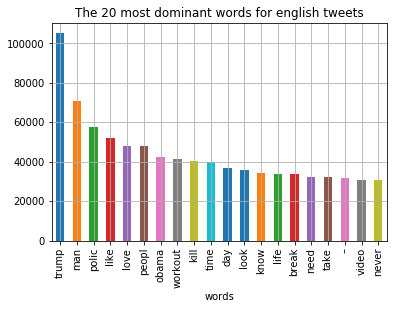

In [39]:
# Select the 20 most frequent words
pre_query = """WITH word_freq AS(SELECT words, COUNT(tweetid) AS frequency FROM tweets_flat_sql GROUP BY words)
SELECT * FROM word_freq ORDER BY frequency DESC LIMIT(20)"""

words_count_df = spark.sql(pre_query)
words_count_df.show()

# Plot purposes
words_count_df.toPandas().plot.bar(x = "words", y = "frequency",legend=False, title="The 20 most dominant words for english tweets",grid=True)

Without any surprise the most frequent word is trump. Some other interesting words also appear such as 
* obama : Obama was a great supporter of the main opponent of Trump that is Hillary Clinton. A theory would be that the trolls tried to discredit Obama's opinion
* black : A word with a negative connotation. Trump supporters are considered by many to be racist.
* kill : Again another word with negative connotation. A lot of interpretations are possible here.

**Now for the russian tweets**

In [56]:
flattered_tweets = translated_ru.rdd.map(lambda r: (r[0],tweet_cleaner(r[1]).split()))

# Going back to dataframes to enjoy the "explode" methods that does exactly what we need
tweets_new_df = spark.createDataFrame(flattered_tweets, ['tweetid','tweet_text'])

# Create another SQL view for questions with this new representation
tweets_new_df.withColumn('words', explode(tweets_new_df.tweet_text)).createOrReplaceTempView("tweets_flat_sql")

+---------+---------+
|    words|frequency|
+---------+---------+
|  russian|      198|
|     year|      185|
|   russia|      171|
|    peopl|      165|
|ukrainian|      150|
|   ukrain|      137|
|      day|      116|
|    today|      113|
|      die|      107|
|     kill|      105|
|   memori|      104|
|     hero|      104|
| children|       96|
|  support|       75|
|    world|       74|
|  countri|       71|
|     live|       70|
| american|       67|
|    putin|       63|
|    state|       63|
+---------+---------+



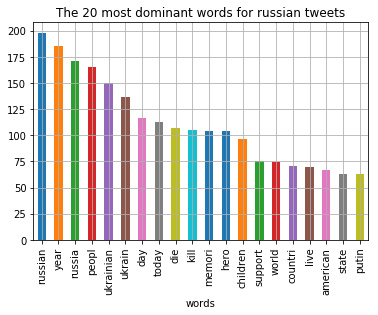

In [57]:
# Select the 20 most frequent words
pre_query = """WITH word_freq AS(SELECT words, COUNT(tweetid) AS frequency FROM tweets_flat_sql GROUP BY words)
SELECT * FROM word_freq ORDER BY frequency DESC LIMIT(20)"""

words_count_df = spark.sql(pre_query)
words_count_df.show()

# Plot purposes
words_count_df.toPandas().plot.bar(x = "words", y = "frequency",legend=False, title="The 20 most dominant words for russian tweets",grid=True)

While the 3 most used words (russian-year-russia) don't bring any useful information, the interesting thing to note is the presence of both ukrainian and ukrain in the top 6 ! This confirms the previous section in showing that the Ukrain is a highly contraversated subject in Russia. 
Russian trolls are naturally more focus on local subjects such as Ukrain or the genocide of Donbass with words such as children or memories. 
Nevertheless the attentive reader may notice the presence of the word american at position 18. 


**Comparison with most common words for all twitter account**

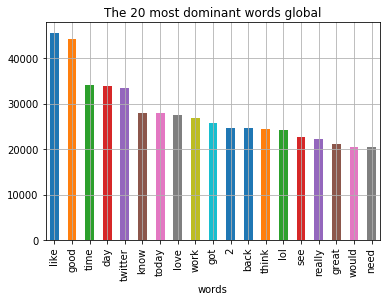

In [22]:
"""Clean the list from http://techland.time.com/2009/06/08/the-500-most-frequently-used-words-on-twitter/ and
remove every stopword of the list."""
words_file = open('most_popular_words.txt', 'r')
most_popular_words = [] # Most popular words for normal users
score_list = [] # Number of occurences
for raw_word in words_file:
    cleaned_word = ''
    i = 0
    while raw_word[i] != '=': # Convert to correct string
        cleaned_word += raw_word[i]
        i += 1
    re.sub(r'[.,"!,-;]+', '', cleaned_word, flags=re.MULTILINE) # Remove punctuation
    if stemmer.stem(cleaned_word) not in stopwords: # remove stopwords
        most_popular_words.append(cleaned_word)
        score_list.append(int(raw_word[i+1:])) 
words_file.close()

popular_words_df = pd.DataFrame(data = {'words' : most_popular_words[0:19], 'frequency' : score_list[0:19]})
print(popular_words_df)
popular_words_df. plot.bar(x = "words", y = "frequency",legend=False, title="The 20 most dominant words global",grid=True)

The biggest difference between is obviously the total absence of the word Trump for the normal users ! This indicates well how Trump is a particularly specific topic for the english trolls. 
Furthemore, except for the word love, one could argue that the words used by the english trolls seem to be more negative that those used by the rest of the world. This is illustrated by words such as kill, break, never and shoot for the trolls, where other prefer words such as good, lol, great.

### Support or hate ?

What we can do to illustrate the this is called a ***sentiment analysis***. This problem is a classification problem that tries to classifiy a tweet as 'positive' or 'negative'. While it doesn't totally answer to the question 5, it is still a good start that will be reused in the popularity of Trump and Hillary analysis.

**Naive analysis**

The first analysis that we perform is inspired by https://github.com/jeffreybreen/twitter-sentiment-analysis-tutorial-201107.
    It is quite naive as it just looks at the words themseleves and not the whole sentence.
    E.g. "I'm not happy" will be identified as positive.

The first step of this sentiment analysis is to define words that we consider to be respectively positive, negative.

In [131]:
def read_file(file):
    f = open(file, 'r')
    words = []
    for word in f:
        words += [stemmer.stem(word[:len(word)-2])]
    f.close()
    return words

# Build the negative and positive word lists
neg_words = read_file('negative.txt')
print('Negative words : ' + str(neg_words))
pos_words = read_file('positive.txt')
print('Positive words : ' + str(pos_words))

Negative words : ['2-face', '2-face', 'abnorma', 'aboli', 'abominabl', 'abominabl', 'abominat', 'abominatio', 'abor', 'abort', 'abort', 'abrad', 'abrasiv', 'abrup', 'abruptl', 'abscon', 'absenc', 'absent-mind', 'absent', 'absur', 'absurdit', 'absurdl', 'absurdn', 'abus', 'abus', 'abus', 'abusiv', 'abysma', 'abysmal', 'abi', 'accidenta', 'acco', 'accurs', 'accusatio', 'accus', 'accus', 'accus', 'accusin', 'accusingl', 'acerbat', 'acerbi', 'acerbical', 'ach', 'ach', 'ach', 'ach', 'achin', 'acri', 'acridl', 'acridn', 'acrimoniou', 'acrimoniousl', 'acrimon', 'adaman', 'adamantl', 'addic', 'addict', 'addictin', 'addict', 'admoni', 'admonish', 'admonishingl', 'admonishmen', 'admonitio', 'adulterat', 'adulter', 'adulteratio', 'adulteri', 'adversaria', 'adversar', 'adver', 'adversit', 'afflic', 'afflictio', 'afflictiv', 'affron', 'afrai', 'aggravat', 'aggravatin', 'aggravatio', 'aggressio', 'aggressiv', 'aggressiven', 'aggresso', 'aggriev', 'aggriev', 'aggrivatio', 'agha', 'agoni', 'agoniz', '

Let us now build our naive predictor

In [132]:
# Predict
def sentiment_prediction(sentence):
    """Predict neutral, positive and negative depending on the words in the sentence"""
    neg = 0
    pos = 0
    sentence = sentence.lower()
    words = sentence.split(' ')
    for word in words:
        stemmed_word = stemmer.stem(word)
        if stemmed_word in neg_words:
            neg = neg + 1
        if stemmed_word in pos_words:
            pos = pos + 1
    if pos == neg:
        return 'neutral'
    elif pos > neg:
        return 'positive'
    else:
        return 'negative'
    
print('Example, I hate Trump is : ' + sentiment_prediction('I hate Trump'))

Example, I hate Trump is : negative


#### English tweets

Let us now apply this analysis on the english tweets 

In [133]:
# Predict each tweet with the above method
prediction_rdd = df_en.rdd.map(lambda r: (r[0],r[1], r[2], sentiment_prediction(tweet_cleaner(r[2]))))
prediction_df = spark.createDataFrame(prediction_rdd, ['tweetid','tweet_language', 'tweet_text', 'prediction']) # New dataframe
prediction_df.show()

+------------------+--------------+--------------------+----------+
|           tweetid|tweet_language|          tweet_text|prediction|
+------------------+--------------+--------------------+----------+
|410398623537459201|            en|sdjsdkklds;msd #s...|   neutral|
|433129902322094080|            en|We've got 24/7  l...|   neutral|
|448064376994791424|            en|lol Josh's facial...|   neutral|
|449192066078089216|            en|watch #COMEBACKHO...|  positive|
|455308717844856833|            en|I'm not hiding an...|   neutral|
|459307743913197569|            en|I don't see how p...|   neutral|
|459349490634194945|            en|i could live off ...|   neutral|
|461004310151979008|            en|Just remembered I...|  negative|
|466232108005203969|            en|thinks that sex i...|  positive|
|478251669344358400|            en|Lack of money is ...|  negative|
|478511300750753792|            en|I've discovered 2...|   neutral|
|479563599879622656|            en|       I'm so

Let us compare the number of positive and negative tweets in our all tweets

In [134]:
# Let us see the count of every prediction
prediction_df.createOrReplaceTempView("prediction_sql")

pred_count_df = spark.sql('SELECT prediction, COUNT(tweetid) AS frequency FROM prediction_sql GROUP BY prediction')
pred_count_df.show()

+----------+---------+
|prediction|frequency|
+----------+---------+
|  positive|   426954|
|   neutral|  1032638|
|  negative|   649470|
+----------+---------+



And plot the results as a pie chart

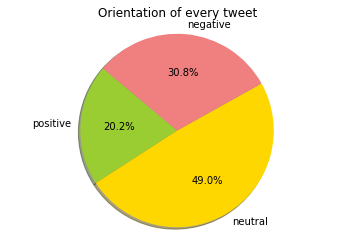

In [135]:
# Data to plot
pred_count_df_pd = pred_count_df.toPandas()
labels = pred_count_df_pd['prediction']
sizes = pred_count_df_pd['frequency']
colors = ['yellowgreen', 'gold', 'lightcoral']
 
# Plot
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.title('Orientation of every tweet')
plt.show()

As we can see the tweets seem to be more negative than positive (given our naive algorithm)

A much more interesting idea would be to apply the same reasoning but only for the tweets containing the word 'Trump', 'Obama' and 'Hillary'. That way, we will be able to see if the tweets related to Trump, Obama or Hillary were more positive or negative.

The first step consists of selecting the tweets containing respectively the word Trump, Hillary and Obama

In [136]:
# Count predictions' orentiations for Trump tweets
query_prediction = """WITH trump_tweet AS (SELECT tweetId, prediction FROM prediction_sql WHERE tweet_text LIKE '%Trump%')

SELECT prediction, COUNT(tweetid) AS frequency FROM trump_tweet GROUP BY prediction"""

pred_trump_count_df = spark.sql(query_prediction)
pred_trump_count_pd = pred_trump_count_df.toPandas()

In [137]:
# Count predictions' orentiations for Obama tweets
query_prediction = """WITH obama_tweet AS (SELECT tweetId, prediction FROM prediction_sql WHERE tweet_text LIKE '%Obama%')

SELECT prediction, COUNT(tweetid) AS frequency FROM obama_tweet GROUP BY prediction"""

pred_obama_count_df = spark.sql(query_prediction)
pred_obama_count_pd = pred_obama_count_df.toPandas()

In [138]:
# Count predictions' orentiations for Hillary tweets
query_prediction = """WITH hillary_tweet AS (SELECT tweetId, prediction FROM prediction_sql WHERE tweet_text LIKE '%Hillary%')

SELECT prediction, COUNT(tweetid) AS frequency FROM hillary_tweet GROUP BY prediction"""

pred_hillary_count_df = spark.sql(query_prediction)
pred_hillary_count_pd = pred_hillary_count_df.toPandas()

And plot the results stacked bars

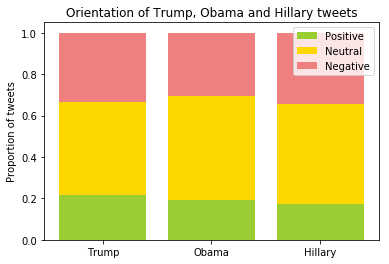

In [139]:
# Plot stacked bars
ind = np.arange(3)
positive_trump = pred_trump_count_pd.loc[pred_trump_count_pd['prediction'] == 'positive']['frequency'].values[0]
neutral_trump = pred_trump_count_pd.loc[pred_trump_count_pd['prediction'] == 'neutral']['frequency'].values[0]
negative_trump = pred_trump_count_pd.loc[pred_trump_count_pd['prediction'] == 'negative']['frequency'].values[0]
total = positive_trump + neutral_trump + negative_trump
positive_trump /= total
neutral_trump /= total
negative_trump /= total

positive_obama = pred_obama_count_pd.loc[pred_obama_count_pd['prediction'] == 'positive']['frequency'].values[0]
neutral_obama = pred_obama_count_pd.loc[pred_obama_count_pd['prediction'] == 'neutral']['frequency'].values[0]
negative_obama = pred_obama_count_pd.loc[pred_obama_count_pd['prediction'] == 'negative']['frequency'].values[0]
total = positive_obama + neutral_obama + negative_obama
positive_obama /= total
neutral_obama /= total
negative_obama /= total

positive_hillary = pred_hillary_count_pd.loc[pred_hillary_count_pd['prediction'] == 'positive']['frequency'].values[0]
neutral_hillary = pred_hillary_count_pd.loc[pred_hillary_count_pd['prediction'] == 'neutral']['frequency'].values[0]
negative_hillary = pred_hillary_count_pd.loc[pred_hillary_count_pd['prediction'] == 'negative']['frequency'].values[0]
total = positive_hillary + neutral_hillary + negative_hillary
positive_hillary /= total
neutral_hillary /= total
negative_hillary /= total

positives = [positive_trump, positive_obama, positive_hillary]
neutrals = [neutral_trump, neutral_obama, neutral_hillary]
negatives = [negative_trump, negative_obama, negative_hillary]

p1 = plt.bar(ind, positives, color='yellowgreen')
p2 = plt.bar(ind, neutrals, color='gold', bottom = positives)
p3 = plt.bar(ind, negatives, color='lightcoral', bottom = [x+y for x,y in zip(neutrals, positives)])

plt.ylabel('Proportion of tweets')
plt.title('Orientation of Trump, Obama and Hillary tweets')
plt.xticks(ind, ('Trump', 'Obama', 'Hillary'))
plt.legend((p1[0], p2[0], p3[0]), ('Positive', 'Neutral', 'Negative'))

From these observations we can already observe that the tweets the more polarised are those talking about Trump. As for the sentiments of the tweets themselves, the big loser seemes to be Hillary which has lowest positivity score and a negativity score more or less equal to this of Trump. On the opposite, Trump is the big winner in term of positive tweets.

**More complex analysis**

We will now apply a much more powerful tool to perform sentiment analysis : **VaderSentimentAnalyser** and see if the tendancy remains the same that in the naive case.

In [21]:
analyzer = SentimentIntensityAnalyzer() # Initiate analyser

In [22]:
# Positive analysis
pos_rdd = df_en.rdd.map(lambda r: (r[0],r[2], analyzer.polarity_scores(tweet_cleaner_vader(r[2]))['pos']))
pos_df_en = spark.createDataFrame(pos_rdd, ['tweetid', 'tweet_text', 'pos_score']) # New dataframe
pos_df_en.show()

+------------------+--------------------+---------+
|           tweetid|          tweet_text|pos_score|
+------------------+--------------------+---------+
|410398623537459201|sdjsdkklds;msd #s...|      0.0|
|433129902322094080|We've got 24/7  l...|      0.0|
|448064376994791424|lol Josh's facial...|    0.567|
|449192066078089216|watch #COMEBACKHO...|    0.316|
|455308717844856833|I'm not hiding an...|    0.095|
|459307743913197569|I don't see how p...|      0.0|
|459349490634194945|i could live off ...|      0.0|
|461004310151979008|Just remembered I...|      0.0|
|466232108005203969|thinks that sex i...|    0.061|
|478251669344358400|Lack of money is ...|      0.0|
|478511300750753792|I've discovered 2...|      0.0|
|479563599879622656|       I'm so hungry|      0.0|
|483723533181538304|Life without love...|      0.0|
|483741982528139264|Feel like a littl...|    0.195|
|486895755349987328|forever in love h...|    0.677|
|488555401643048961|life is a journey...|      0.0|
|48910603143

Let us now plot the density of positivity among the english tweets

Text(0,0.5,'Density of tweets')

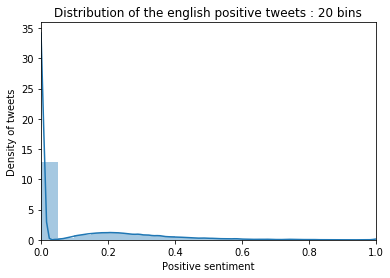

In [23]:
sns.distplot(pos_df_en.select('pos_score').toPandas(),bins=20)
plt.xlim([0,1])
plt.title('Distribution of the english positive tweets : 20 bins')
plt.xlabel('Positive sentiment')
plt.ylabel('Density of tweets')

In [24]:
# Negative analysis
neg_rdd = df_en.rdd.map(lambda r: (r[0],r[2], analyzer.polarity_scores(tweet_cleaner_vader(r[2]))['neg']))
neg_df_en = spark.createDataFrame(neg_rdd, ['tweetid', 'tweet_text', 'neg_score']) # New dataframe
neg_df_en.show()

+------------------+--------------------+---------+
|           tweetid|          tweet_text|neg_score|
+------------------+--------------------+---------+
|410398623537459201|sdjsdkklds;msd #s...|      0.0|
|433129902322094080|We've got 24/7  l...|      0.0|
|448064376994791424|lol Josh's facial...|      0.0|
|449192066078089216|watch #COMEBACKHO...|      0.0|
|455308717844856833|I'm not hiding an...|    0.184|
|459307743913197569|I don't see how p...|      0.0|
|459349490634194945|i could live off ...|      0.0|
|461004310151979008|Just remembered I...|    0.351|
|466232108005203969|thinks that sex i...|      0.0|
|478251669344358400|Lack of money is ...|      0.7|
|478511300750753792|I've discovered 2...|      0.0|
|479563599879622656|       I'm so hungry|      0.0|
|483723533181538304|Life without love...|    0.406|
|483741982528139264|Feel like a littl...|    0.181|
|486895755349987328|forever in love h...|      0.0|
|488555401643048961|life is a journey...|      0.0|
|48910603143

In [ ]:
sns.distplot(neg_df_en.select('neg_score').toPandas(),bins=20)
plt.xlim([0,1])
plt.title('Distribution of the english negative tweets : 20 bins')
plt.xlabel('Negative sentiment')
plt.ylabel('Density of tweets')

Now let us focus, just as before, on the tweets containing Obama, Hillary and Trump. And perform a positive **and** negative analysis on
both of them.

**Note :** Here we will ignore the scores of 0.0 for plotting visibility 

**Negative Analysis for Trump, Hillary and Obama**

In [26]:
# Select the tweets that contain the word Trump
neg_df_en.createOrReplaceTempView("neg_en_sql")
query_prediction = """SELECT tweetid, neg_score FROM neg_en_sql WHERE tweet_text LIKE '%Trump%' AND neg_score!=0"""

pred_trump_df = spark.sql(query_prediction)

In [27]:
# Select the tweets that contain the word Obama
query_prediction = """SELECT tweetid, neg_score FROM neg_en_sql WHERE tweet_text LIKE '%Obama%' AND neg_score!=0"""

pred_obama_df = spark.sql(query_prediction)

In [28]:
# Select the tweets that contain the word Hillary
query_prediction = """SELECT tweetid, neg_score FROM neg_en_sql WHERE tweet_text LIKE '%Hillary%' AND neg_score!=0"""

pred_hillary_df = spark.sql(query_prediction)

Text(0,0.5,'Number of tweets')

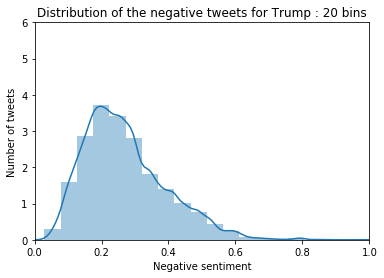

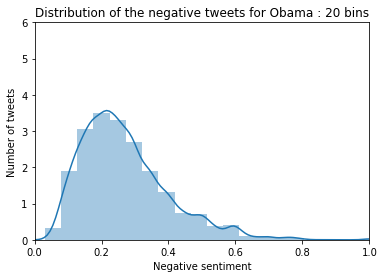

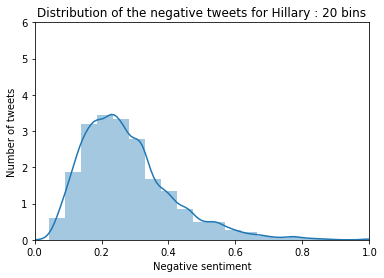

In [29]:
# Plot the distributions
plt.figure(1)
sns.distplot(pred_trump_df.select('neg_score').toPandas(),bins=20)
plt.xlim([0,1])
plt.ylim([0,6])
plt.title('Distribution of the negative tweets for Trump : 20 bins')
plt.xlabel('Negative sentiment')
plt.ylabel('Density of tweets')
plt.figure(2)
sns.distplot(pred_obama_df.select('neg_score').toPandas(),bins=20)
plt.xlim([0,1])
plt.ylim([0,6])
plt.title('Distribution of the negative tweets for Obama : 20 bins')
plt.xlabel('Negative sentiment')
plt.ylabel('Density of tweets')
plt.figure(3)
sns.distplot(pred_hillary_df.select('neg_score').toPandas(),bins=20)
plt.xlim([0,1])
plt.ylim([0,6])
plt.title('Distribution of the negative tweets for Hillary : 20 bins')
plt.xlabel('Negative sentiment')
plt.ylabel('Density of tweets')

**Positive analysis for Trump, Hillary and Obama**

In [30]:
# Select the tweets that contain the word Trump
pos_df_en.createOrReplaceTempView("pos_en_sql")
query_prediction = """SELECT tweetid, pos_score FROM pos_en_sql WHERE tweet_text LIKE '%Trump%' AND pos_score!=0"""

pred_trump_df_2 = spark.sql(query_prediction)

In [31]:
# Select the tweets that contain the word Obama
query_prediction = """SELECT tweetid, pos_score FROM pos_en_sql WHERE tweet_text LIKE '%Obama%' AND pos_score!=0"""

pred_obama_df_2 = spark.sql(query_prediction)

In [32]:
# Select the tweets that contain the word Hillary
query_prediction = """SELECT tweetid, pos_score FROM pos_en_sql WHERE tweet_text LIKE '%Hillary%' AND pos_score!=0"""

pred_hillary_df_2 = spark.sql(query_prediction)

Text(0,0.5,'Number of tweets')

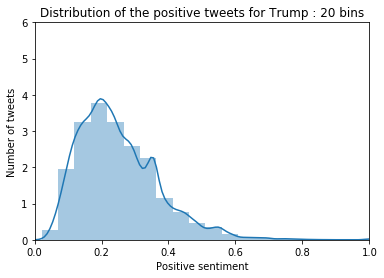

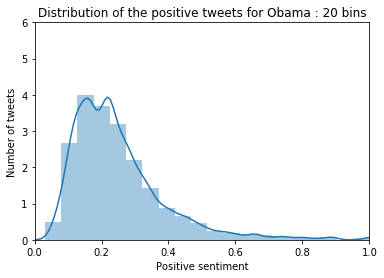

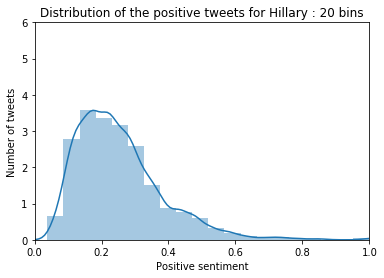

In [33]:
# Plot the distributions
plt.figure(1)
sns.distplot(pred_trump_df_2.select('pos_score').toPandas(),bins=20)
plt.xlim([0,1])
plt.ylim([0,6])
plt.title('Distribution of the positive tweets for Trump : 20 bins')
plt.xlabel('Positive sentiment')
plt.ylabel('Density of tweets')
plt.figure(2)
sns.distplot(pred_obama_df_2.select('pos_score').toPandas(),bins=20)
plt.xlim([0,1])
plt.ylim([0,6])
plt.title('Distribution of the positive tweets for Obama : 20 bins')
plt.xlabel('Positive sentiment')
plt.ylabel('Density of tweets')
plt.figure(3)
sns.distplot(pred_hillary_df_2.select('pos_score').toPandas(),bins=20)
plt.xlim([0,1])
plt.ylim([0,6])
plt.title('Distribution of the positive tweets for Hillary : 20 bins')
plt.xlabel('Positive sentiment')
plt.ylabel('Density of tweets')

The results are quite difficult to analyse for the moment, nevertheless these results will be used in the popularity analysis.

### Now for the Russian tweets 

**naive analysis**

Same procedure as before

In [92]:
# Predict each tweet with the above method
prediction_rdd = translated_ru.rdd.map(lambda r: (r[0],r[1], sentiment_prediction(tweet_cleaner(r[1]))))
prediction_df = spark.createDataFrame(prediction_rdd, ['tweetid', 'tweet_text', 'prediction']) # New dataframe
prediction_df.show()

+------------------+--------------------+----------+
|           tweetid|          tweet_text|prediction|
+------------------+--------------------+----------+
|888352384812019712|Marin Le Pen: We ...|  positive|
|883700663208824832|Elena Prikhodko, ...|  negative|
|838736168640466944|Is Litvinova okay...|   neutral|
|696384621601300480|Ahahaha HTTPS://T...|   neutral|
|884345115363487744|On July 10, 2016 ...|   neutral|
|747049705104891904|"Bobyon is" the "...|   neutral|
|870263243431964672|"Vanichka Nesteru...|   neutral|
|781441079564468224|39-year-old resid...|  negative|
|704991386874019840|Northern Venice ?...|   neutral|
|734372506300256256|Kiev was going to...|   neutral|
|660440831283888128|All those who tod...|  negative|
|757853549615124481|Pushkov called Ru...|  positive|
|805075503329722368|URGENT NEWS! Syri...|   neutral|
|502409560368623617|"Putin saw his ra...|  positive|
|760002770246197248|The Islamic State...|  negative|
|676811008262995969|"This is the" Pin...|   ne

Once again let us look how many tweets are neutral, positive or negative

In [93]:
# Let us see the count of every prediction
prediction_df.createOrReplaceTempView("prediction_sql")

pred_count_df = spark.sql('SELECT prediction, COUNT(tweetid) AS frequency FROM prediction_sql GROUP BY prediction')
pred_count_df.show()

+----------+---------+
|prediction|frequency|
+----------+---------+
|  positive|      693|
|   neutral|     1257|
|  negative|      767|
+----------+---------+



Similarly to the previous analysis, one could be interested about what Russian trolls think of Russia and Ukrain. One could expect that the Ukrain related tweets should be negative as a result of the tensions that exist between both countries. On the other hand, the Russia related tweets are expected to be more positive since they come from supposed nationalist people.

In [94]:
# Count predictions' orentiations for Ukrain tweets
query_prediction = """WITH ukrain_tweet AS (SELECT tweetid, prediction FROM prediction_sql WHERE tweet_text LIKE '%Ukrain%')

SELECT prediction, COUNT(tweetid) AS frequency FROM ukrain_tweet GROUP BY prediction"""

pred_ukrain_count_df = spark.sql(query_prediction)
pred_ukrain_count_pd = pred_ukrain_count_df.toPandas()

In [95]:
# Count predictions' orentiations for Obama tweets
query_prediction = """WITH russia_tweet AS (SELECT tweetid, prediction FROM prediction_sql WHERE tweet_text LIKE '%Russia%')

SELECT prediction, COUNT(tweetid) AS frequency FROM russia_tweet GROUP BY prediction"""

pred_russia_count_df = spark.sql(query_prediction)
pred_russia_count_pd = pred_russia_count_df.toPandas()

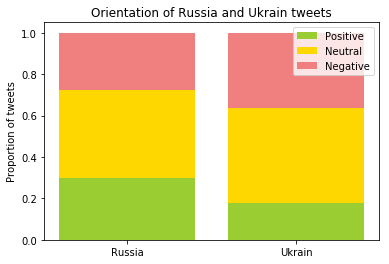

In [96]:
# Plot stacked bars
ind = np.arange(2)
positive_russia = pred_russia_count_pd.loc[pred_russia_count_pd['prediction'] == 'positive']['frequency'].values[0]
neutral_russia = pred_russia_count_pd.loc[pred_russia_count_pd['prediction'] == 'neutral']['frequency'].values[0]
negative_russia = pred_russia_count_pd.loc[pred_russia_count_pd['prediction'] == 'negative']['frequency'].values[0]
total = positive_russia + neutral_russia + negative_russia
positive_russia /= total
neutral_russia /= total
negative_russia /= total

positive_ukrain = pred_ukrain_count_pd.loc[pred_ukrain_count_pd['prediction'] == 'positive']['frequency'].values[0]
neutral_ukrain = pred_ukrain_count_pd.loc[pred_ukrain_count_pd['prediction'] == 'neutral']['frequency'].values[0]
negative_ukrain = pred_ukrain_count_pd.loc[pred_ukrain_count_pd['prediction'] == 'negative']['frequency'].values[0]
total = positive_ukrain + neutral_ukrain + negative_ukrain
positive_ukrain /= total
neutral_ukrain /= total
negative_ukrain /= total

positives = [positive_russia, positive_ukrain]
neutrals = [neutral_russia, neutral_ukrain]
negatives = [negative_russia, negative_ukrain]

p1 = plt.bar(ind, positives, color='yellowgreen')
p2 = plt.bar(ind, neutrals, color='gold', bottom = positives)
p3 = plt.bar(ind, negatives, color='lightcoral', bottom = [x+y for x,y in zip(neutrals, positives)])

plt.ylabel('Proportion of tweets')
plt.title('Orientation of Russia and Ukrain tweets')
plt.xticks(ind, ('Russia', 'Ukrain'))
plt.legend((p1[0], p2[0], p3[0]), ('Positive', 'Neutral', 'Negative'))

The results are exactly the one expected, the Ukrain related tweets tend to be **much** more negative that those about Russia. The opposite holds for the positive tweets as well. 

**More complex analysis**

Let us now perform the same analysis as above but this time with a higher level sentiment analyser

In [15]:
# Positive analysis
pos_rdd = translated_ru.rdd.map(lambda r: (r[0],r[1], float(analyzer.polarity_scores(tweet_cleaner_vader(r[1]))['pos'])))
pos_df = spark.createDataFrame(pos_rdd, ['tweetid', 'tweet_text', 'pos_score']) # New dataframe

Let us now plot the density of positivity among the russian tweets

Text(0,0.5,'Density of tweets')

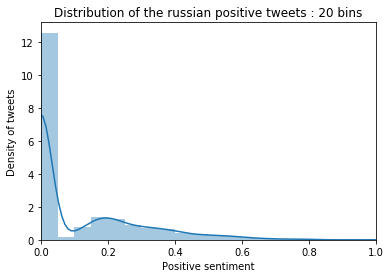

In [16]:
sns.distplot(pos_df.select('pos_score').toPandas(),bins=20)
plt.xlim([0,1])
plt.title('Distribution of the russian positive tweets : 20 bins')
plt.xlabel('Positive sentiment')
plt.ylabel('Density of tweets')

Same procedure now for the negative sentiment

In [17]:
# Negative analysis
neg_rdd = translated_ru.rdd.map(lambda r: (r[0],r[1], analyzer.polarity_scores(tweet_cleaner(r[1]))['neg']))
neg_df = spark.createDataFrame(neg_rdd, ['tweetid', 'tweet_text', 'neg_score']) # New dataframe
neg_df.show()

+------------------+--------------------+---------+
|           tweetid|          tweet_text|neg_score|
+------------------+--------------------+---------+
|888352384812019712|Marin Le Pen: We ...|      0.0|
|883700663208824832|Elena Prikhodko, ...|    0.187|
|838736168640466944|Is Litvinova okay...|      0.0|
|696384621601300480|Ahahaha HTTPS://T...|      0.0|
|884345115363487744|On July 10, 2016 ...|    0.272|
|747049705104891904|"Bobyon is" the "...|      0.0|
|870263243431964672|"Vanichka Nesteru...|      0.0|
|781441079564468224|39-year-old resid...|      0.0|
|704991386874019840|Northern Venice ?...|      0.0|
|734372506300256256|Kiev was going to...|      0.0|
|660440831283888128|All those who tod...|    0.398|
|757853549615124481|Pushkov called Ru...|      0.0|
|805075503329722368|URGENT NEWS! Syri...|      0.0|
|502409560368623617|"Putin saw his ra...|      0.0|
|760002770246197248|The Islamic State...|      0.0|
|676811008262995969|"This is the" Pin...|      0.0|
|73181971558

Text(0,0.5,'Density of tweets')

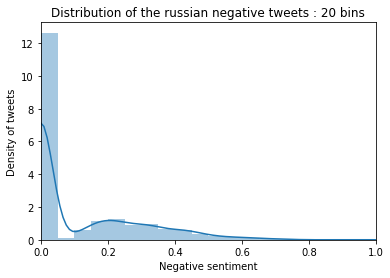

In [18]:
sns.distplot(neg_df.select('neg_score').toPandas(),bins=20)
plt.xlim([0,1])
plt.title('Distribution of the russian negative tweets : 20 bins')
plt.xlabel('Negative sentiment')
plt.ylabel('Density of tweets')

Let us now compare once again the negativity distribution of the tweets talking about Russia and Ukrain.

**Note :** Here we will ignore the scores of 0.0 for plotting visibility 

Negative analysis for Russia and Ukrain

In [101]:
# Select the tweets that contain the word Ukrain
neg_df.createOrReplaceTempView("neg_sql")
query_prediction = """SELECT tweetid, neg_score FROM neg_sql WHERE tweet_text LIKE '%Ukrain%' AND neg_score!=0"""

pred_ukrain_count_df = spark.sql(query_prediction)

In [102]:
# Select the tweets that contain the word Russia
query_prediction = """SELECT tweetid, neg_score FROM neg_sql WHERE tweet_text LIKE '%Russia%' AND neg_score!=0"""

pred_russia_count_df = spark.sql(query_prediction)

Text(0,0.5,'Number of sentences')

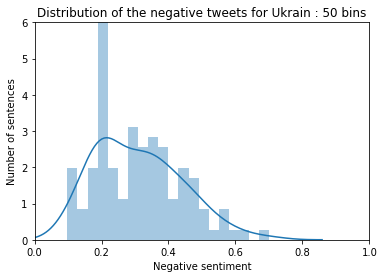

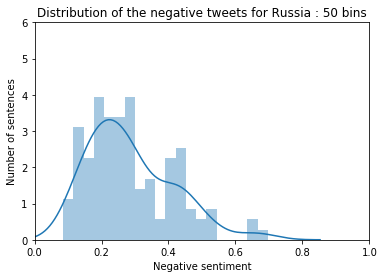

In [103]:
plt.figure(1)
sns.distplot(pred_ukrain_count_df.select('neg_score').toPandas(),bins=20)
plt.xlim([0,1])
plt.ylim([0,6])
plt.title('Distribution of the negative tweets for Ukrain : 50 bins')
plt.xlabel('Negative sentiment')
plt.ylabel('Density of tweets)
plt.figure(2)
sns.distplot(pred_russia_count_df.select('neg_score').toPandas(),bins=20)
plt.xlim([0,1])
plt.ylim([0,6])
plt.title('Distribution of the negative tweets for Russia : 50 bins')
plt.xlabel('Negative sentiment')
plt.ylabel('Density of tweets')

Same as before, it is difficult to pronounce ourselves on those tweets for the moment, we leave that for the next part.

### Saving it all
Now that the sentiment analysis has been made, we can save positive and negative for both the naive and vaderAnalyser methods, as they will be needed for studying their impacts on popularity

In [41]:
# All Trump tweets
trump_query = """SELECT tweetid, prediction FROM prediction_sql WHERE tweet_text LIKE '%Trump%'"""

trump_df = spark.sql(trump_query)
trump_df.createOrReplaceTempView("trump_sql")

# Save positives and negative naive Trump tweets into parquets
pos_query = """SELECT tweetid FROM trump_sql WHERE prediction LIKE '%positive%'"""
neg_query = """SELECT tweetid FROM trump_sql WHERE prediction LIKE '%negative%'"""

spark.sql(pos_query).write.mode('overwrite').parquet("pos_trump_naive")
spark.sql(neg_query).write.mode('overwrite').parquet("neg_trump_naive")

In [42]:
# All Obama tweets
obama_query = """SELECT tweetid, prediction FROM prediction_sql WHERE tweet_text LIKE '%Obama%'"""

obama_df = spark.sql(obama_query)
obama_df.createOrReplaceTempView("obama_sql")

# Save positives and negative naive Obama tweets into parquets
pos_query = """SELECT tweetid FROM obama_sql WHERE prediction LIKE '%positive%'"""
neg_query = """SELECT tweetid FROM obama_sql WHERE prediction LIKE '%negative%'"""

spark.sql(pos_query).write.mode('overwrite').parquet("pos_obama_naive")
spark.sql(neg_query).write.mode('overwrite').parquet("neg_obama_naive")

In [43]:
# All Hillary tweets
hillary_query = """SELECT tweetid, prediction FROM prediction_sql WHERE tweet_text LIKE '%Hillary%'"""

hillary_df = spark.sql(hillary_query)
hillary_df.createOrReplaceTempView("hillary_sql")

# Save positives and negative naive Hillary tweets into parquets
pos_query = """SELECT tweetid FROM hillary_sql WHERE prediction LIKE '%positive%'"""
neg_query = """SELECT tweetid FROM hillary_sql WHERE prediction LIKE '%negative%'"""

spark.sql(pos_query).write.mode('overwrite').parquet("pos_hillary_naive")
spark.sql(neg_query).write.mode('overwrite').parquet("neg_hillary_naive")

In [34]:
# Save positives and negative vader Trump tweets into parquets
pos_query = """SELECT tweetid FROM pos_en_sql WHERE pos_score > 0.2 AND tweet_text LIKE '%Trump%'"""
neg_query = """SELECT tweetid FROM neg_en_sql WHERE neg_score > 0.2 AND tweet_text LIKE '%Trump%'"""

spark.sql(pos_query).write.mode('overwrite').parquet("pos_trump_vader")
spark.sql(neg_query).write.mode('overwrite').parquet("neg_trump_vader")

In [35]:
# Save positives and negative vader Trump tweets into parquets
pos_query = """SELECT tweetid FROM pos_en_sql WHERE pos_score > 0.2 AND tweet_text LIKE '%Obama%'"""
neg_query = """SELECT tweetid FROM neg_en_sql WHERE neg_score > 0.2 AND tweet_text LIKE '%Obama%'"""

spark.sql(pos_query).write.mode('overwrite').parquet("pos_obama_vader")
spark.sql(neg_query).write.mode('overwrite').parquet("neg_obama_vader")

In [36]:
# Save positives and negative vader Trump tweets into parquets
pos_query = """SELECT tweetid FROM pos_en_sql WHERE pos_score > 0.2 AND tweet_text LIKE '%Hillary%'"""
neg_query = """SELECT tweetid FROM neg_en_sql WHERE neg_score > 0.2 AND tweet_text LIKE '%Hillary%'"""

spark.sql(pos_query).write.mode('overwrite').parquet("pos_hillary_vader")
spark.sql(neg_query).write.mode('overwrite').parquet("neg_hillary_vader")

**NOTE** :  The following sections will intensively use PySpark SQL embedded features. 

### Time window :  Period 1 (*US 2012 Elections and Vladimir Putin elections*)
Small interactions with US 2012 elections and easy to spot intra-Russia tweets about the elections.

In [72]:
# select normal tweets of the current time period 
normal_tweets_p1_query = """SELECT * 
                            FROM normal_tweets_sql
                            WHERE tweet_time >= "2012-02-01" AND tweet_time <= "2013-06-30"
                        """
normal_tweets_p1_df  = spark.sql(normal_tweets_p1_query)

normal_tweets_p1_df.createOrReplaceTempView("normal_tweets_p1_sql")

In [73]:
# group by week and sort by time 
normal_dates_w_p1_query =  """SELECT COUNT(tweetid) AS count,MAX(tweet_time) AS time 
                              FROM normal_tweets_p1_sql 
                              GROUP BY CAST(DATEDIFF(tweet_time,"2012-02-01")/7 AS int)
                              ORDER BY time ASC
                           """
normal_dates_w_p1_df = spark.sql(normal_dates_w_p1_query)

# store as a Panda dataframe (very small, absolutely no problem with the memory)
normal_dates_w_p1_pd = normal_dates_w_p1_df.toPandas()

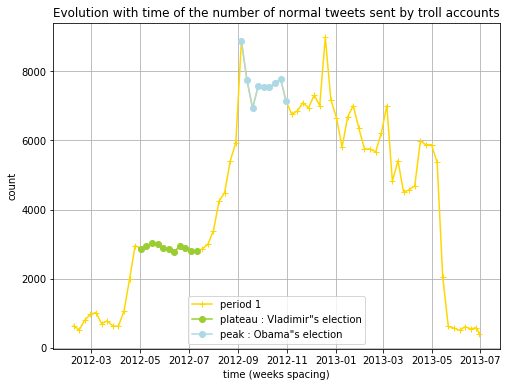

In [74]:
# plot intermediate results
plt.figure(figsize=(8,6))
plt.plot(normal_dates_w_p1_pd["time"],normal_dates_w_p1_pd["count"],color="gold",marker='+')
plateau = normal_dates_w_p1_pd[(normal_dates_w_p1_pd.time>="2012-05-01") & (normal_dates_w_p1_pd.time<="2012-07-15")]
peak = normal_dates_w_p1_pd[(normal_dates_w_p1_pd.time>="2012-09-01") & (normal_dates_w_p1_pd.time<="2012-11-6")]
plt.plot(plateau["time"],plateau["count"],color="yellowgreen",marker='o')
plt.plot(peak["time"],peak["count"],color="lightblue",marker='o')
plt.title('Evolution with time of the number of normal tweets sent by troll accounts')
plt.grid()
plt.xlabel('time (weeks spacing)')
plt.ylabel('count')
plt.legend(['period 1','plateau : Vladimir"s election','peak : Obama"s election'],loc=8);

Let's investigate tweets addressed directly to *Obama* / politics on that same time window.

In [40]:
# stop words more specifically addressed to Obama (after a review : nothing interesting embedding Clinton nor Trump)
stop_words_political_p1 = ['barack','obama','барак','обама','democrat','демократ']

In [42]:
# get texts of the normal tweets corresponding to period 1
normal_tweets_texts_p1_query = """ SELECT normal_tweets_p1_sql.tweetid,tweet_language,tweet_text,userid,tweet_time,like_count,retweet_count,hashtags,urls
                                   FROM tweets_text_sql JOIN normal_tweets_p1_sql ON tweets_text_sql.tweetid == normal_tweets_p1_sql.tweetid
                               """

normal_tweets_texts_p1_df = spark.sql(normal_tweets_texts_p1_query)


## Parquet transformation 

# @comment if Parquet already built
# normal_tweets_texts_p1_df.write.mode('overwrite').parquet("normal_tweets_texts_p1_df")

normal_tweets_texts_p1_df = spark.read.parquet("normal_tweets_texts_p1_df")

# replace/update previous Spark SQL temporary view
normal_tweets_texts_p1_df.createOrReplaceTempView("normal_tweets_texts_p1_sql")

In [43]:
political_normal_tweets_texts_p1_df = normal_tweets_texts_p1_df.rdd.filter(lambda x: any(word in x.tweet_text.lower() for word in stop_words_political_p1))

# @comment if Parquet already built
# political_normal_tweets_texts_p1_df.toDF().write.mode('overwrite').parquet("political_tweets_texts_p1_df")

political_normal_tweets_texts_p1_df = spark.read.parquet("political_tweets_texts_p1_df")

In [44]:
political_normal_tweets_texts_p1_df.createOrReplaceTempView("political_tweets_texts_p1_sql")

# group by week political tweets of period 1
political_normal_dates_w_p1_query =   """SELECT COUNT(tweetid) AS count,MAX(tweet_time) AS time 
                                         FROM political_tweets_texts_p1_sql 
                                         GROUP BY CAST(DATEDIFF(tweet_time,"2012-02-01")/7 AS int)
                                         ORDER BY time ASC
                                      """
political_normal_dates_w_p1_df = spark.sql(political_normal_dates_w_p1_query)

# store as a Panda dataframe (very small, absolutely no problem with the memory)
political_normal_dates_w_p1_pd = political_normal_dates_w_p1_df.toPandas()

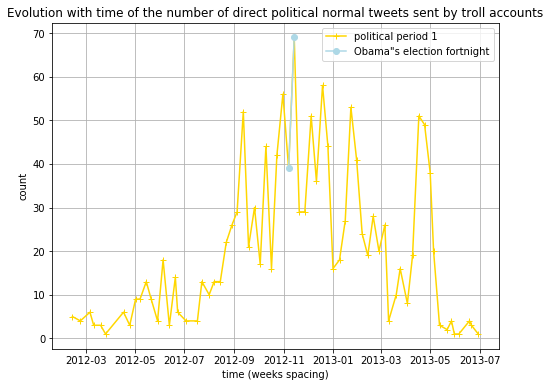

In [45]:
plt.figure(figsize=(8,6))
election_week = political_normal_dates_w_p1_pd[(political_normal_dates_w_p1_pd.time>="2012-11-01")&(political_normal_dates_w_p1_pd.time<="2012-11-20")]
plt.plot(political_normal_dates_w_p1_pd["time"],political_normal_dates_w_p1_pd["count"],color="gold",marker='+')
plt.plot(election_week["time"],election_week["count"],color='lightblue',marker='o')
plt.title('Evolution with time of the number of direct political normal tweets sent by troll accounts')
plt.grid()
plt.xlabel('time (weeks spacing)')
plt.ylabel('count')
plt.legend(['political period 1','Obama"s election fortnight'],loc=1);

The trend is confirmed and more localized around *Obama's* election. The rest of the tweets were sent to other purposes than the US 2012 elections. As one can see, trollers from IRA are not really interested yet by US elections. As we will see there will be much more attraction for 2016's elections because of interests' conflicts between USA/RUS. 

Let's see what are the most 10 RT among those *Obama* and political tweets and their content. 

We are interested to see whether or not they already deliver hatred contents. 

In [46]:
# get the 10 (it could be more or less) most RT tweets for political period 1

political_period_1_rt_counts_top_query =     """SELECT tweetid,userid,retweet_count,tweet_time,urls,tweet_text,tweet_language,like_count,hashtags
                                                FROM political_tweets_texts_p1_sql
                                                ORDER BY retweet_count DESC
                                                LIMIT 10
                                             """
political_period_1_rt_counts_top_df = spark.sql(political_period_1_rt_counts_top_query)

# to Pandas for further analysis
political_period_1_rt_counts_top_pd = political_period_1_rt_counts_top_df.toPandas()

# quick view on the users 
political_period_1_rt_counts_top_pd

,tweetid,userid,retweet_count,tweet_time,urls,tweet_text,tweet_language,like_count,hashtags
0,298419891134922752,449689677,8,2013-02-04 13:17:00,None,Давайте перенесемся в 1991 год. Вспомним все н...,ru,1,None
1,175859009235075072,466549101,3,2012-03-03 08:23:00,None,"""""""Когда вы будете вводить демократию с помощь...",und,0,None
2,283556556958748672,5860f89ab2d44cd6d24965203492416e263c5f607b7d63...,3,2012-12-25 12:55:00,None,Царь в моей голове отрёкся от престола. Теперь...,ru,1,[ПозитивГода]
3,265490089013022720,466549101,2,2012-11-05 16:25:00,[http://www.bbc.co.uk/russian/international/20...,А завтра United States presidential election. ...,und,0,"[USA, election]"
4,279719115969658880,2a2383f1a63d6ba732eb854df2866671632bf956322bba...,2,2012-12-14 22:46:00,[http://bit.ly/SqNvwO],Барак Обама подписал «закон Магнитского» http:...,ru,0,[новости]
5,175859572857249792,466549101,2,2012-03-03 08:26:00,None,"""""""Таким образом демократия не вводится""""""",und,0,None
6,169063653226725377,466549101,2,2012-02-13 14:21:00,None,Достигнуты договоренности о сотрудничестве с «...,und,1,None
7,266657238100353025,2a2383f1a63d6ba732eb854df2866671632bf956322bba...,2,2012-11-08 21:43:00,[http://bit.ly/Z8nXUt],Обама посетит Россию в 2013 году http://t.co/v...,und,0,[новости]
8,333246665635004416,466549101,2,2013-05-11 15:46:00,[http://mobile.bbc.co.uk/russian/international...,Первые демократические #выборы в #Пакистан'е п...,ru,0,"[выборы, Пакистан]"
9,281007664950034433,aa6d42bfd479088dd39ad698cb7a465be95403eb34720a...,2,2012-12-18 12:07:00,None,"Единый день голосования - вот где демократия,...",ru,0,[БолотныйТупик]


In [47]:
# print plain tweet text 
iterator = 1
for elem in political_period_1_rt_counts_top_pd['tweet_text']:
    print(iterator)
    iterator=iterator+1
    print(elem)

1
Давайте перенесемся в 1991 год. Вспомним все надежды, на демократию, Ельцина, радость от краха КПСС, и посмотрим на нашу действительность.
2
"""Когда вы будете вводить демократию с помощью оружия
3
Царь в моей голове отрёкся от престола. Теперь у меня демократия #ПозитивГода
4
А завтра United States presidential election. Рейтинги @BarackObama и @MittRomney практически равны http://t.co/abBeWx5z #USA #election
5
Барак Обама подписал «закон Магнитского» http://t.co/y7uYSKT1 #новости
6
"""Таким образом демократия не вводится"""
7
Достигнуты договоренности о сотрудничестве с «Лигой избирателей», «Демократической правовой Россией», «Открытой трибуной», обществ.деятелями
8
Обама посетит Россию в 2013 году http://t.co/vATDhr36 #новости
9
Первые демократические #выборы в #Пакистан'е прошли на фоне взрывов и стрельбы. Власти отмечают высокую явку http://t.co/r2ezTHKvLA
10
Единый день голосования  - вот где демократия, вот где нужно было вступать в конфронтацию с властью #БолотныйТупик


Translation of symbolic tweets : 

-  first tweet : "*Let's fast forward to 1991. Recall all hopes for democracy, Yeltsin, the joy of the collapse of the CPSU, and look at our reality.*"
- second tweet : "*When will you introduce democracy with weapons?*"
- nineth tweet : "*Obama fell off his bike and suffered responsibility for the & lt; & lt; terrorist attack & gt; & gt; a terrorist group from & lt; & lt; Al-Qaida;*"

Not all the tweets are related to Obama (some are about russian feelings) but the ones highlighted above are quite expressive. 
Trollers often use gross/violent language and send content of hate sometimes ($9th$ tweet).

### Time window : Period 2 (*Hiring Time*)

Recall : we observe increasing troll activity immediately time-correlated to the start of the well known armed conflict in Ukrainia. The semantic analysis performed above already showed the overall support tweets from IRA tried to send through. 

In [88]:
# select normal tweets of the current time period 
normal_tweets_p2_query = """SELECT * 
                            FROM normal_tweets_sql
                            WHERE tweet_time > "2013-11-30" AND tweet_time <= "2014-05-31"
                        """
normal_tweets_p2_df  = spark.sql(normal_tweets_p2_query)

normal_tweets_p2_df.createOrReplaceTempView("normal_tweets_p2_sql")

In [89]:
# group by week and sort by time 
normal_dates_w_p2_query = """SELECT COUNT(tweetid) AS count,MAX(tweet_time) AS time 
                             FROM normal_tweets_p2_sql 
                             GROUP BY CAST(DATEDIFF(tweet_time,"2013-12-01")/7 AS int)
                             ORDER BY time ASC
                          """
normal_dates_w_p2_df = spark.sql(normal_dates_w_p2_query)

# store as a Panda dataframe (very small, absolutely no problem with the memory)
normal_dates_w_p2_pd = normal_dates_w_p2_df.toPandas()

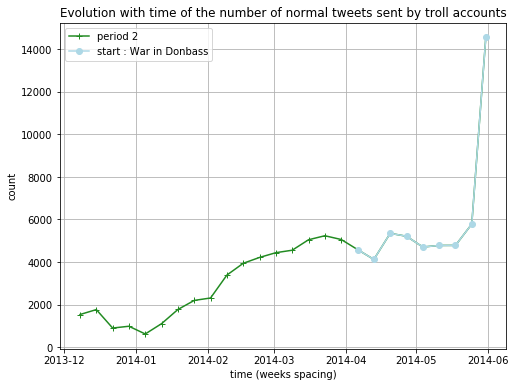

In [90]:
# plot intermediate results
plt.figure(figsize=(8,6))
plt.plot(normal_dates_w_p2_pd["time"],normal_dates_w_p2_pd["count"],color="forestgreen",marker='+')
war = normal_dates_w_p2_pd[(normal_dates_w_p2_pd.time>="2014-04-01")]
plt.plot(war["time"],war["count"],color="lightblue",marker='o')
plt.title('Evolution with time of the number of normal tweets sent by troll accounts')
plt.grid()
plt.xlabel('time (weeks spacing)')
plt.ylabel('count')
plt.legend(['period 2','start : War in Donbass'],loc=2);

As [wikipedia/war in Donbass](https://en.wikipedia.org/wiki/War_in_Donbass) tells us. Ukraine's armed conflict started around March-April 2014, then with some latency trollers began their job apparently. Prior to those events a calm period had been observed, Ukrain's troubles seemed to trigger the trollers again.  

### Time window :  Period 3 (*War in Donbass*)
This period of time doesn't concern immediately US elections. Still we can observe trolls reactions to the actuality events ; especially in what concerns the war in Donbass. 

Here below we structurate the code as usual. 

In [109]:
# select normal tweets of the current time period 
normal_tweets_p3_query = """SELECT * 
                            FROM normal_tweets_sql
                            WHERE tweet_time > "2014-05-31" AND tweet_time <= "2014-12-31"
                        """
normal_tweets_p3_df  = spark.sql(normal_tweets_p3_query)

normal_tweets_p3_df.createOrReplaceTempView("normal_tweets_p3_sql")

In [110]:
# group by week and sort by time 
normal_dates_w_p3_query = """SELECT COUNT(tweetid) AS count,MAX(tweet_time) AS time 
                             FROM normal_tweets_p3_sql 
                             GROUP BY CAST(DATEDIFF(tweet_time,"2014-05-31")/7 AS int)
                             ORDER BY time ASC
                          """
normal_dates_w_p3_df = spark.sql(normal_dates_w_p3_query)

# store as a Panda dataframe (very small, absolutely no problem with the memory)
normal_dates_w_p3_pd = normal_dates_w_p3_df.toPandas()

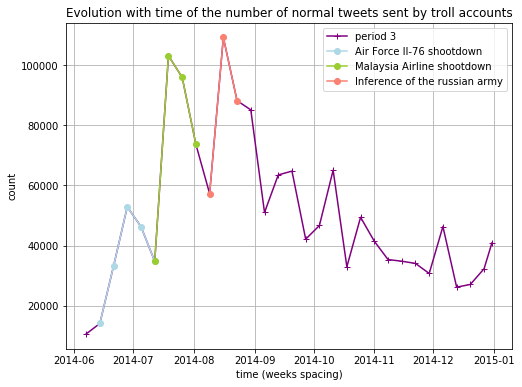

In [111]:
# plot intermediate results

# /!\ 2014 Ukrainian Air Force Il-76 shootdown : occured the 14th of June 2014
peak_aircraft1 = normal_dates_w_p3_pd[(normal_dates_w_p3_pd.time>="2014-06-10") & (normal_dates_w_p3_pd.time<="2014-07-15")]

# /!\ Vol 17 Malaysia Airlines : occured the 17th of July 2014
peak_aircraft2 = normal_dates_w_p3_pd[(normal_dates_w_p3_pd.time>="2014-07-10") & (normal_dates_w_p3_pd.time<="2014-08-05")]

# /!\ leadership transition => citizens to militaries around mid August 2014
peak_leadership_transition = normal_dates_w_p3_pd[(normal_dates_w_p3_pd.time>="2014-08-05") & (normal_dates_w_p3_pd.time<="2014-08-28")]

plt.figure(figsize=(8,6))
plt.plot(normal_dates_w_p3_pd["time"],normal_dates_w_p3_pd["count"],color="purple",marker='+')
plt.plot(peak_aircraft1["time"],peak_aircraft1["count"],color="lightblue",marker='o')
plt.plot(peak_aircraft2["time"],peak_aircraft2["count"],color="yellowgreen",marker='o')
plt.plot(peak_leadership_transition["time"],peak_leadership_transition["count"],color="salmon",marker="o")
plt.title('Evolution with time of the number of normal tweets sent by troll accounts')
plt.grid()
plt.xlabel('time (weeks spacing)')
plt.ylabel('count')
plt.legend(['period 3','Air Force Il-76 shootdown','Malaysia Airline shootdown','Inference of the russian army'],loc=1);
plt.savefig('temp3.png',format='png', dpi=1000,transparent = True)

### Time window :  Period 4 (*US 2016 Elections*)

Let's now focus on the period of time corresponding to the whole presidential campaign (+ some time before as a flourishing speculative period)

In [140]:
# select normal tweets of the current time period 
normal_tweets_p4_query = """SELECT * 
                            FROM normal_tweets_sql
                            WHERE tweet_time > "2014-12-31" AND tweet_time <= "2016-11-07"
                        """
normal_tweets_p4_df  = spark.sql(normal_tweets_p4_query)

normal_tweets_p4_df.createOrReplaceTempView("normal_tweets_p4_sql")

In [141]:
# group by week and sort by time 
normal_dates_w_p4_query = """SELECT COUNT(tweetid) AS count,MAX(tweet_time) AS time 
                             FROM normal_tweets_p4_sql 
                             GROUP BY CAST(DATEDIFF(tweet_time,"2014-12-31")/7 AS int)
                             ORDER BY time ASC
                          """
normal_dates_w_p4_df = spark.sql(normal_dates_w_p4_query)

# store as a Panda dataframe (very small, absolutely no problem with the memory)
normal_dates_w_p4_pd = normal_dates_w_p4_df.toPandas()

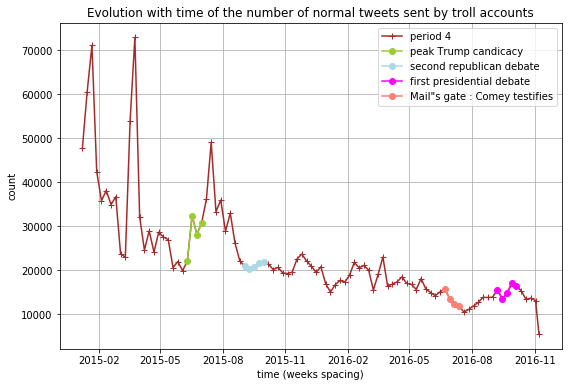

In [142]:
# plot intermediate results

# /!\ occured the 6th of June 2015
peak_candidacy_trump = normal_dates_w_p4_pd[(normal_dates_w_p4_pd.time>="2015-06-09") & (normal_dates_w_p4_pd.time<="2015-07-02")]

# /!\ second republican debate held on 16th of Sep 2015
peak_second_debate = normal_dates_w_p4_pd[(normal_dates_w_p4_pd.time>="2015-09-01") & (normal_dates_w_p4_pd.time<="2015-10-02")]

# /!\ first presidential debate (after primaires) on the 26 of september 
peak_first_pres_debate = normal_dates_w_p4_pd[(normal_dates_w_p4_pd.time>="2016-09-04") & (normal_dates_w_p4_pd.time<="2016-10-05")]

# /!\ Senate probes Loretta Lynch interference (Wikipedia) => H. Clinton's mails gate
peak_mail_gate = normal_dates_w_p4_pd[(normal_dates_w_p4_pd.time>="2016-06-15") & (normal_dates_w_p4_pd.time<="2016-07-15")]

plt.figure(figsize=(9,6))
plt.plot(normal_dates_w_p4_pd["time"],normal_dates_w_p4_pd["count"],color="brown",marker='+')
plt.plot(peak_candidacy_trump["time"],peak_candidacy_trump["count"],color='yellowgreen',marker='o')
plt.plot(peak_second_debate["time"],peak_second_debate["count"],color='lightblue',marker='o')
plt.plot(peak_first_pres_debate["time"],peak_first_pres_debate["count"],color='magenta',marker="o")
plt.plot(peak_mail_gate["time"],peak_mail_gate["count"],color="salmon",marker='o')
plt.title('Evolution with time of the number of normal tweets sent by troll accounts')
plt.grid()
plt.xlabel('time (weeks spacing)')
plt.ylabel('count')
plt.legend(['period 4','peak Trump candicacy','second republican debate','first presidential debate','Mail"s gate : Comey testifies'],loc=1);

(For the explanation of the detected peaks, please refer to the second graph about directly politically related tweets.)

We can see that peaks of the second graph do not always match with the most prominent peaks within the overall frequency distribution of troll tweets (presence of other topics !)

In [143]:
# get texts of the normal tweets corresponding to period 4
normal_tweets_texts_p4_query = """ SELECT normal_tweets_p4_sql.tweetid,tweet_language,tweet_text,userid,tweet_time,like_count,retweet_count,hashtags,urls
                                   FROM tweets_text_sql JOIN normal_tweets_p4_sql ON tweets_text_sql.tweetid == normal_tweets_p4_sql.tweetid
                               """

normal_tweets_texts_p4_df = spark.sql(normal_tweets_texts_p4_query)

## Parquet transformation 

# @comment if Parquet already built
#normal_tweets_texts_p4_df.write.mode('overwrite').parquet("normal_tweets_texts_p4_df")

normal_tweets_texts_p4_df = spark.read.parquet("normal_tweets_texts_p4_df")

# replace/update previous Spark SQL temporary view
normal_tweets_texts_p4_df.createOrReplaceTempView("normal_tweets_texts_p4_sql")

Let's now investigate the correlations between events of actuality and short period aggregated troll tweets counts (overall and/or politically related). 

In order to detect politically related tweets we also need to store some obvious stop words.

In [144]:
stop_words_political = ['donald','trump','дональд','трамп','hillary','clinton','хиллари','клинтон',\
                        'barack','obama','барак','обама','republican','республиканец','democrat','демократ',\
                        'presidential','elections','выборы','президента','votes','голосов','fake news','fakenews','поддельные',\
                       'новости']

In [145]:
# filter with political stop words 
political_normal_tweets_texts_p4_df = normal_tweets_texts_p4_df.rdd.filter(lambda x: any(word in x.tweet_text for word in stop_words_political))

# @comment if Parquet already built
# political_normal_tweets_texts_p4_df.toDF().write.mode('overwrite').parquet("political_tweets_texts_p4_df")

political_normal_tweets_texts_p4_df = spark.read.parquet("political_tweets_texts_p4_df")

In [146]:
political_normal_tweets_texts_p4_df.createOrReplaceTempView("political_normal_tweets_p4_sql")

# group and count by weeks (only the weeks of interest corresponding to the current time window) 
political_normal_dates_w_p4_query =   """SELECT COUNT(tweetid) AS count,MAX(tweet_time) AS time 
                                         FROM political_normal_tweets_p4_sql 
                                         GROUP BY CAST(DATEDIFF(tweet_time,"2014-12-31")/7 AS int)
                                         ORDER BY time ASC
                                      """
political_normal_dates_w_p4_df = spark.sql(political_normal_dates_w_p4_query)

# store as a Panda dataframe (very small, absolutely no problem with the memory)
political_normal_dates_w_p4_pd = political_normal_dates_w_p4_df.toPandas()

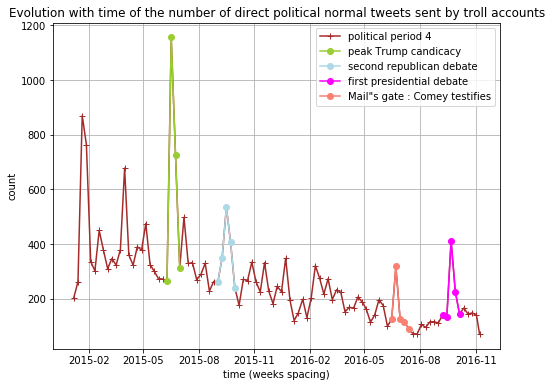

In [147]:
# plotting time

# /!\ occured the 6th of June 2015
peak_candidacy_trump = political_normal_dates_w_p4_pd[(political_normal_dates_w_p4_pd.time>="2015-06-09") & (political_normal_dates_w_p4_pd.time<="2015-07-02")]

# /!\ second republican debate held on 16th of Sep 2015
peak_second_debate = political_normal_dates_w_p4_pd[(political_normal_dates_w_p4_pd.time>="2015-09-01") & (political_normal_dates_w_p4_pd.time<="2015-10-02")]

# /!\ first presidential debate (after primaires) on the 26 of september 
peak_first_pres_debate = political_normal_dates_w_p4_pd[(political_normal_dates_w_p4_pd.time>="2016-09-04") & (political_normal_dates_w_p4_pd.time<="2016-10-05")]

# /!\ Senate probes Loretta Lynch interference (Wikipedia) => H. Clinton's mails gate
peak_mail_gate = political_normal_dates_w_p4_pd[(political_normal_dates_w_p4_pd.time>="2016-06-10") & (political_normal_dates_w_p4_pd.time<="2016-07-15")]

plt.figure(figsize=(8,6))
plt.plot(political_normal_dates_w_p4_pd["time"],political_normal_dates_w_p4_pd["count"],color="brown",marker='+')
plt.plot(peak_candidacy_trump["time"],peak_candidacy_trump["count"],color='yellowgreen',marker='o')
plt.plot(peak_second_debate["time"],peak_second_debate["count"],color='lightblue',marker='o')
plt.plot(peak_first_pres_debate["time"],peak_first_pres_debate["count"],color='magenta',marker='o')
plt.plot(peak_mail_gate["time"],peak_mail_gate["count"],color="salmon",marker='o')
plt.title('Evolution with time of the number of direct political normal tweets sent by troll accounts')
plt.grid()
plt.xlabel('time (weeks spacing)')
plt.ylabel('count')
plt.legend(['political period 4','peak Trump candicacy','second republican debate','first presidential debate','Mail"s gate : Comey testifies'],loc=1);

We have succeeded in spotting some peaks immediately related to campaign's events ! 

Now, in order to get a **qualitative** effect of the trolls tweets we will display : 

                - intentions of vote (polls) and directly politically related tweets vs. time
                
and in order to get a **quantitatitve** effect of the prolls tweets we compute :

                 - aggregated sentimental scores per week and per opponent (Trump vs. Clinton).

Since this is the period that interests us the most to talk about we scrapped data from a popularity/intention of votes analysis from . We put side to side the volume of direct political troll tweets and the polls ([realclearpolitics/polls](https://www.realclearpolitics.com/epolls/latest_polls/president/#) starting within the primaries of US 2016 elections) for both H. Clinton and D.J Trump. 

In [59]:
# import intentions of vote during and after primaries
ap_clinton_trump_votes = pd.read_excel(DATA_DIR+'trump_hillary.xlsx')

In [60]:
# time spacing with 1st of april (date for which our dataset scrapped begins)
datelist = pd.date_range("2016-04-01", periods=221).tolist()

In [61]:
# focus on the last months (days) of the elections (only getting direct politically related tweets) 
political_normal_dates_ap_d_p4_query =    """SELECT COUNT(tweetid) AS count,MAX(tweet_time) AS time 
                                             FROM political_normal_tweets_p4_sql 
                                             WHERE tweet_time >="2016-03-01"
                                             GROUP BY YEAR(tweet_time),MONTH(tweet_time),DAY(tweet_time)
                                             ORDER BY YEAR(tweet_time),MONTH(tweet_time),DAY(tweet_time) ASC
                                          """
political_normal_dates_ap_d_p4_df = spark.sql(political_normal_dates_ap_d_p4_query)

# store as a Panda dataframe (very small, absolutely no problem with the memory)
political_normal_dates_ap_d_p4_pd = political_normal_dates_ap_d_p4_df.toPandas()

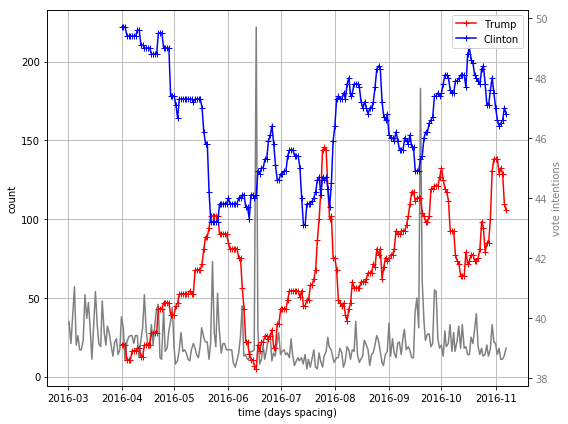

Vote Intentions & Directly Politically related Tweets vs. Time


In [62]:
# https://matplotlib.org/gallery/api/two_scales.html

fig, ax1 = plt.subplots(figsize=(8,6))

color = 'grey'
ax1.set_xlabel('time (days spacing)')
ax1.set_ylabel('count', color= "black")
ax1.plot(political_normal_dates_ap_d_p4_pd['time'], political_normal_dates_ap_d_p4_pd['count'], color='grey')
ax1.tick_params(axis='y', labelcolor="black")

ax1.grid()
ax2 = ax1.twinx()  # instantiate a second axis that shares the same x-axis

ax2.set_ylabel('vote intentions', color=color) 
ax2.plot(datelist,ap_clinton_trump_votes['Trump'], color="red",marker='+')
ax2.plot(datelist,ap_clinton_trump_votes['Hillary'], color="blue",marker='+')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['Trump','Clinton'],loc=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
print('Vote Intentions & Directly Politically related Tweets vs. Time')

Unfortunately we cannot assess a direct link between politically related tweets (in overall) and the intention of votes... 
A lot of different social media sources must be taken into account, it's really hard to get significant results only based on the given datasets. Most of the interesting statistics about social influence / popularity scores ... etc are chargeable (you must pay for them), also we should have had access to studies (for instance the studies used by [paper/AllCott-US2016-fakeNews](https://www.aeaweb.org/articles?id=10.1257/jep.31.2.211) to get an insight on how are people affected by the presence of the well established troll tweets. 

The existence of trolls is undeniable (examples are to follow below) but their spread to american citizens (or more globally, for all tweets' topics, human beings) is really tough. Nevertheless we can try to quantify the hatred leaning of the tweets themselves ; it will give us informations about how ***could*** be affected the people who read them ! 

Here below one can find, along a timeline, the results of the *vader* sentimental analysis. 

In [158]:
# read of Parquet files about sentiment analysis => only reported english written tweets

neg_hillary_vader = spark.read.parquet("neg_hillary_vader")
neg_trump_vader = spark.read.parquet("neg_trump_vader")
neg_obama_vader = spark.read.parquet("neg_obama_vader")

pos_hillary_vader = spark.read.parquet("pos_hillary_vader")
pos_trump_vader = spark.read.parquet("pos_trump_vader")
pos_obama_vader = spark.read.parquet("pos_obama_vader")

After the sentimental analysis of tweets written in **english** : 
- identified (positively or negatively) troll tweets about either *D.J. Trump*, *B. Obama* and *H. Clinton* are joined to their user, retweet_counts, ... etc 

In [161]:
def rejoin_query(name):
    return """SELECT normal_tweets_sql.tweetid,userid,tweet_time,in_reply_to_userid,quoted_tweet_tweetid,quote_count,reply_count,like_count,retweet_count,hashtags,urls,user_mentions,poll_choices FROM normal_tweets_sql JOIN """ +name+ " ON normal_tweets_sql.tweetid == "+name+".tweetid"

neg_hillary_vader.createOrReplaceTempView("neg_hillary_vader_sql")
neg_trump_vader.createOrReplaceTempView("neg_trump_vader_sql")
neg_obama_vader.createOrReplaceTempView("neg_obama_vader_sql")

pos_hillary_vader.createOrReplaceTempView("pos_hillary_vader_sql")
pos_trump_vader.createOrReplaceTempView("pos_trump_vader_sql")
pos_obama_vader.createOrReplaceTempView("pos_obama_vader_sql")

## HILLARY CLINTON 

neg_hillary_vader_df = spark.sql(rejoin_query("neg_hillary_vader_sql"))
# @comment if Parquet already built
#neg_hillary_vader_df.write.mode('overwrite').parquet("neg_hil_vader")
neg_hillary_vader_df = spark.read.parquet("neg_hil_vader")

pos_hillary_vader_df = spark.sql(rejoin_query("pos_hillary_vader_sql"))
# @comment if Parquet already built
#pos_hillary_vader_df.write.mode('overwrite').parquet("pos_hil_vader")
pos_hillary_vader_df = spark.read.parquet("pos_hil_vader")

## BARACK OBAMA

neg_obama_vader_df = spark.sql(rejoin_query("neg_obama_vader_sql"))
# @comment if Parquet already built
#neg_obama_vader_df.write.mode('overwrite').parquet("neg_oba_vader")
neg_obama_vader_df = spark.read.parquet("neg_oba_vader")

pos_obama_vader_df = spark.sql(rejoin_query("pos_obama_vader_sql"))
# @comment if Parquet already built
#pos_obama_vader_df.write.mode('overwrite').parquet("pos_oba_vader")
pos_obama_vader_df = spark.read.parquet("pos_oba_vader")

## DONALD TRUMP

neg_trump_vader_df = spark.sql(rejoin_query("neg_trump_vader_sql"))
# @comment if Parquet already built
#neg_trump_vader_df.write.mode('overwrite').parquet("neg_tru_vader")
neg_trump_vader_df = spark.read.parquet("neg_tru_vader")

pos_trump_vader_df = spark.sql(rejoin_query("pos_trump_vader_sql"))
# @comment if Parquet already built
#pos_trump_vader_df.write.mode('overwrite').parquet("pos_tru_vader")
pos_trump_vader_df = spark.read.parquet("pos_tru_vader")

Let's sort and group them by week using integrated/built-in Panda's time window slicer. 

In [162]:
grouped_pos_hillary_vader_w_pd = pos_hillary_vader_df.select(pos_hillary_vader_df.tweet_time,pos_hillary_vader_df.tweetid).toPandas()\
                                                 .set_index('tweet_time').resample('W',how='count')
grouped_neg_hillary_vader_w_pd = neg_hillary_vader_df.select(neg_hillary_vader_df.tweet_time,neg_hillary_vader_df.tweetid).toPandas()\
                                                 .set_index('tweet_time').resample('W',how='count')

grouped_pos_obama_vader_w_pd = pos_obama_vader_df.select(pos_obama_vader_df.tweet_time,pos_obama_vader_df.tweetid).toPandas()\
                                                 .set_index('tweet_time').resample('W',how='count')
grouped_neg_obama_vader_w_pd = neg_obama_vader_df.select(neg_obama_vader_df.tweet_time,neg_obama_vader_df.tweetid).toPandas()\
                                                 .set_index('tweet_time').resample('W',how='count')

grouped_pos_trump_vader_w_pd = pos_trump_vader_df.select(pos_trump_vader_df.tweet_time,pos_trump_vader_df.tweetid).toPandas()\
                                                 .set_index('tweet_time').resample('W',how='count')
grouped_neg_trump_vader_w_pd = neg_trump_vader_df.select(neg_trump_vader_df.tweet_time,neg_trump_vader_df.tweetid).toPandas()\
                                                 .set_index('tweet_time').resample('W',how='count')

Now we are all set-up to make all the necessary plots for the temporal analysis of the sentimental analysis. 

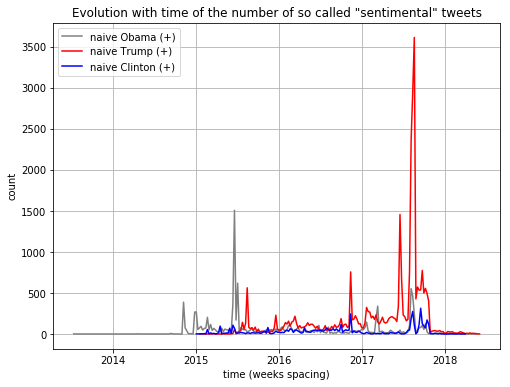

In [163]:
# global evolution of sentiment analysis => positive identified tweets for Clinton, Obama, Trump
plt.figure(figsize=(8,6))
plt.plot(grouped_pos_obama_vader_w_pd,color="grey",ls="-")
plt.plot(grouped_pos_trump_vader_w_pd,color="red",ls="-")
plt.plot(grouped_pos_hillary_vader_w_pd,color="blue",ls="-")
plt.title('Evolution with time of the number of so called "sentimental" tweets')
plt.grid()
plt.xlabel('time (weeks spacing)')
plt.ylabel('count')
plt.legend(['naive Obama (+)','naive Trump (+)','naive Clinton (+)'],loc=2);

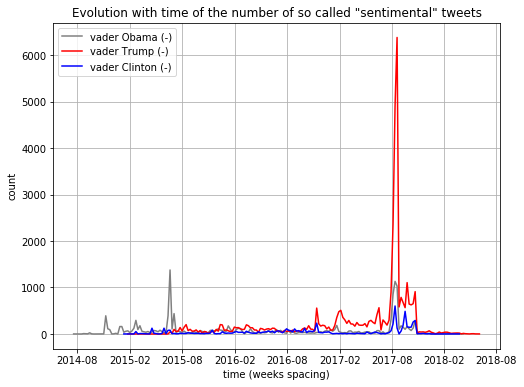

In [164]:
# global evolution of sentiment analysis => negative identified tweets for Clinton, Obama, Trump
plt.figure(figsize=(8,6))
plt.plot(grouped_neg_obama_vader_w_pd,color="grey",ls="-")
plt.plot(grouped_neg_trump_vader_w_pd,color="red",ls="-")
plt.plot(grouped_neg_hillary_vader_w_pd,color="blue",ls="-")
plt.title('Evolution with time of the number of so called "sentimental" tweets')
plt.grid()
plt.xlabel('time (weeks spacing)')
plt.ylabel('count')
#plt.legend(['naive Obama','naive Trump','naive Clinton'],loc=2);
plt.legend(['vader Obama (-)','vader Trump (-)','vader Clinton (-)'],loc=2);

The *sentiment delta* is the difference between the counted *vader*-positive tweets for a candidate and the counted *vader*-negative tweets . 

As a reminder, *vader* is the tool used for our sentimental analysis : [github/vader](https://github.com/cjhutto/vaderSentiment)

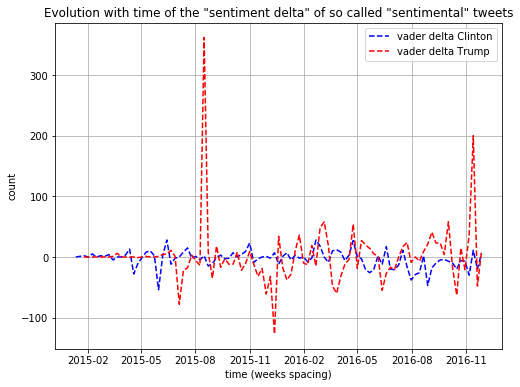

In [165]:
# get the difference between weekly aggregated sentimentally positive and negative number of troll tweets
delta_vader_trump_elections = grouped_pos_trump_vader_w_pd-grouped_neg_trump_vader_w_pd
delta_vader_hillary_elections = grouped_pos_hillary_vader_w_pd-grouped_neg_hillary_vader_w_pd
 
plt.figure(figsize=(8,6))
plt.plot(delta_vader_hillary_elections.loc[:"2016-12-01"],color="blue",ls="--")
plt.plot(delta_vader_trump_elections.loc[:"2016-12-01"],color="red",ls="--")
plt.title('Evolution with time of the "sentiment delta" of so called "sentimental" tweets')
plt.grid()
plt.xlabel('time (weeks spacing)')
plt.ylabel('count')
plt.legend(['vader delta Clinton','vader delta Trump'],loc=1);

Focusing on the entire US 2016 presidential campaign and looking at summary statistics, we actually find out that *Trump* is slightly supported by the troll tweets with respect to Hillary which is, in average, disapproved.

Of course, one has to remain careful while reading those stats since the undertaken sentimental analysis isn't a pure science yet : quite heuristic!

For instance, the trends are too hard to catch and we cannot really tell *how did the strategy of troll accounts vary over time*.

In [166]:
delta_vader_hillary_elections.loc[:"2016-12-01"].describe()

,tweetid
count,99.000000
mean,-3.151515
std,14.054822
min,-54.000000
25%,-9.500000
50%,0.000000
75%,3.000000
max,28.000000


In [167]:
delta_vader_trump_elections.loc[:"2016-12-01"].describe()

,tweetid
count,97.000000
mean,1.525773
std,50.821192
min,-127.000000
25%,-17.000000
50%,0.000000
75%,10.000000
max,362.000000


Let's get some basic statistics about the feature *retweet_count* of the *normal_tweets* of the current period. 

Again, we would like to evaluate/assess the importance of troll tweets. We do not dispose of view counts for such tweets but what can be sure about is that there exists a correlation between the number of views and the number of retweets (the more a post is retweeted, the more likely that it reaches more and more people across the internet).

Summary statistics of *retweet_count*  vs. statistics of typical 'popular' tweets on Twitter to get a kind of 'popularity scale'. Of course we have to be careful with the data we're dealing with : there might be some automatic retweet nested chains that would bias those results. We conducted some experiments about the links of troll accounts between them by a graph-links analysis. 

In [71]:
# get only the retweets counts 
period_4_rt_counts_query = """SELECT retweet_count AS retweets
                              FROM normal_tweets_p4_sql
                           """
period_4_rt_counts_df = spark.sql(period_4_rt_counts_query)

# relative error tolerance for median computation 
tol = 0.001

print('Summary statistics for RT counts for period 4 normal_tweets : ')
print('--------------------------------------------------------------')
period_4_rt_counts_df.select('retweets').describe().show()
print('approx. 1st quarter quantile : '+str(period_4_rt_counts_df.approxQuantile('retweets',[0.25],tol)[0])+\
      ' for relative error of '+str(tol))
print('approx. median : '+str(period_4_rt_counts_df.approxQuantile('retweets',[0.5],tol)[0])+\
      ' for relative error of '+str(tol))
print('approx. 3rd quarter quantile : '+str(period_4_rt_counts_df.approxQuantile('retweets',[0.75],tol)[0])+\
      ' for relative error of '+str(tol))

Summary statistics for RT counts for period 4 normal_tweets : 
--------------------------------------------------------------
+-------+-----------------+
|summary|         retweets|
+-------+-----------------+
|  count|          2250731|
|   mean|5.028659133410434|
| stddev|99.28903534679117|
|    min|                0|
|    max|            97498|
+-------+-----------------+

approx. 1st quarter quantile : 0.0 for relative error of 0.001
approx. median : 0.0 for relative error of 0.001
approx. 3rd quarter quantile : 1.0 for relative error of 0.001


$\Rightarrow$  *stddev* is huge and mean is well above 3rd quantile, those statistics seem to indicate a ***power law*** distribution. 

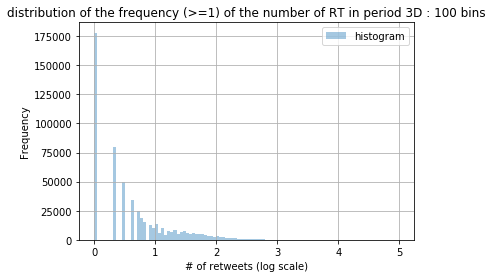

In [79]:
# let's discover the number of normal tweets that were RT more than 10 times for this period
period_4_rt_counts_sup1_query = """SELECT retweet_count AS retweets
                                   FROM normal_tweets_p4_sql
                                   WHERE retweet_count>=1
                                """
period_4_rt_counts_sup1_df = spark.sql(period_4_rt_counts_sup1_query)

# => RT count distribution

## log scale - truncated

# plot purpose  
plt.figure(1)
nbins_global = 100
sns.distplot(period_4_rt_counts_sup1_df.select('retweets').toPandas().apply(lambda x: np.log10(x)),\
             bins = nbins_global, norm_hist = False, kde = False)
plt.title('distribution of the frequency (>=1) of the number of RT in period 3D : ' +\
          str(nbins_global)+' bins')
plt.xlabel('# of retweets (log scale)')
plt.ylabel('Frequency')
plt.grid()
plt.legend(['histogram']);

Among the tweets RT more than $x=10$ times, we can observe the tail under the scope of a zoom ! 

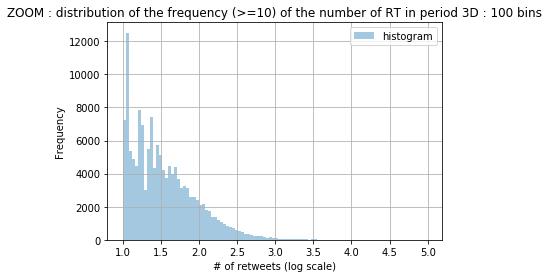

In [80]:
# let's discover the number of normal tweets that were RT more than 10 times for this period
period_4_rt_counts_sup10_query = """SELECT retweet_count AS retweets
                                    FROM normal_tweets_p4_sql
                                    WHERE retweet_count>=10 
                                 """
period_4_rt_counts_sup10_df = spark.sql(period_4_rt_counts_sup10_query)

# => RT count distribution

## log scale - truncated

# plot purpose  
plt.figure(1)
nbins_global = 100
sns.distplot(period_4_rt_counts_sup10_df.select('retweets').toPandas().apply(lambda x: np.log10(x)),\
             bins = nbins_global, norm_hist = False, kde = False)
plt.title('ZOOM : distribution of the frequency (>=10) of the number of RT in period 3D : ' +\
          str(nbins_global)+' bins')
plt.xlabel('# of retweets (log scale)')
plt.ylabel('Frequency')
plt.grid()
plt.legend(['histogram']);

Unfortunately, troll tweets don't seem to differ from the general shape of the frequency count of RT of tweets. 

Indeed, it's actually a well known fact that RT counts follow power laws [paper/example](https://www.sciencedirect.com/science/article/pii/S1877050914005006) , [paper/another_example](https://dl.acm.org/citation.cfm?id=3053903&dl=ACM&coll=DL). 

That being said, it can be interesting to extract the most RT normal tweets and have a look at their content (we keep the *tweetid*'s). 

In [81]:
# get the 1000 (it could be more or less) most RT tweets for period 4

period_4_rt_counts_top_query =     """SELECT tweetid,userid,retweet_count,tweet_time,urls,tweet_text,tweet_language,like_count,hashtags
                                      FROM normal_tweets_texts_p4_sql
                                      ORDER BY retweet_count DESC
                                      LIMIT 1000
                                   """
period_4_rt_counts_top_df = spark.sql(period_4_rt_counts_top_query)

# create temporary Spark SQL view 
period_4_rt_counts_top_df.createOrReplaceTempView("period_4_rt_counts_top_sql")

period_4_rt_counts_top_df.show(10)

+------------------+----------+-------------+-------------------+----+--------------------+--------------+----------+--------------------+
|           tweetid|    userid|retweet_count|         tweet_time|urls|          tweet_text|tweet_language|like_count|            hashtags|
+------------------+----------+-------------+-------------------+----+--------------------+--------------+----------+--------------------+
|780901314079318016|4437233895|        97498|2016-09-27 22:45:00|  []|These emotions......|            en|    136013|                  []|
|785614679682846720|4437233895|        41089|2016-10-10 22:55:00|  []|When It’s slowly ...|            en|     46606|      [BlackTwitter]|
|710499812223918080|3312143142|        28568|2016-03-17 16:15:00|  []|!!!!!!DONT LET TH...|            en|     17639|                  []|
|711543567387332608|3312143142|        25169|2016-03-20 13:23:00|  []|He didn’t want a ...|            en|     14748|                  []|
|708741988481282048|3312143

In [82]:
# get the 1000 (it could be more or less) most RT tweets for period 4 || after primaries and before final votes

ap_period_4_rt_counts_top_query =  """SELECT tweetid,userid,retweet_count,tweet_time,urls,tweet_text,tweet_language,like_count,hashtags
                                      FROM normal_tweets_texts_p4_sql
                                      WHERE tweet_time >= "2016-07-07"
                                      ORDER BY retweet_count DESC
                                      LIMIT 1000
                                   """
ap_period_4_rt_counts_top_df = spark.sql(ap_period_4_rt_counts_top_query)

# create temporary Spark SQL view 
ap_period_4_rt_counts_top_df.createOrReplaceTempView("ap_period_4_rt_counts_top_sql")

# to Pandas for further analysis
ap_period_4_rt_counts_top_pd = ap_period_4_rt_counts_top_df.toPandas()

ap_period_4_rt_counts_top_pd.head(10)

,tweetid,userid,retweet_count,tweet_time,urls,tweet_text,tweet_language,like_count,hashtags
0,780901314079318016,4437233895,97498,2016-09-27 22:45:00,[],These emotions... You can hear the pain in her...,en,136013,[]
1,785614679682846720,4437233895,41089,2016-10-10 22:55:00,[],When It’s slowly becoming illegal for black pe...,en,46606,[BlackTwitter]
2,784182493868023808,4437233895,16627,2016-10-07 00:04:00,[],Normal??? Anti-racism poster gone horribly wr...,en,15020,[]
3,777989058689536000,4437233895,16104,2016-09-19 21:53:00,[],"""""""His life mattered."""" #TerenceCrutcher's t...",en,15185,[TerenceCrutcher]
4,793890171058085888,4224729994,15548,2016-11-02 18:59:00,[],BREAKING: #VoterFraud by counting tens of thou...,en,10172,[VoterFraud]
5,792117761631588352,4437233895,14433,2016-10-28 21:36:00,[],Bus driver sexually assaulted teen girl. Black...,en,10772,[]
6,778619154660204544,1687183549,13316,2016-09-21 15:37:00,[],Wow. Hadn't thought of it that way but that's ...,en,11709,[BlackLivesMatter]
7,785663973613899776,4224729994,12716,2016-10-11 02:11:00,[],"OMG, this new Anti-Hillary ad is brilliant!👌 I...",en,10756,[]
8,790699646096056321,4437233895,11838,2016-10-24 23:41:00,[],Let this picture sink in. Maximize it. Zoom in...,en,7419,[]
9,788450633896562689,4224729994,10824,2016-10-18 18:44:00,[],RT the hell out of it: Dem party operatives: ...,en,6772,[EvangelicalTrump]


In [83]:
ap_period_4_rt_counts_top_pd.loc[7]['tweet_text']

"OMG, this new Anti-Hillary ad is brilliant!👌 It's fantastic!!!!!!  Spread it far &amp; wide! https://t.co/v7zrP8iDl7"

In [84]:
# interesting account
troll_example_p4 = ap_period_4_rt_counts_top_pd[ap_period_4_rt_counts_top_pd.userid=='4224729994']

In [85]:
troll_example_p4.shape

(567, 9)

$56.8\%$ of the 1000 (and $47\%$ of the 100) most RT tweets on the period (July 2016 - November 2016 ; after primaries before final votes) are written by only one troll account ! 

In [86]:
troll_example_p4

,tweetid,userid,retweet_count,tweet_time,urls,tweet_text,tweet_language,like_count,hashtags
4,793890171058085888,4224729994,15548,2016-11-02 18:59:00,[],BREAKING: #VoterFraud by counting tens of thou...,en,10172,[VoterFraud]
7,785663973613899776,4224729994,12716,2016-10-11 02:11:00,[],"OMG, this new Anti-Hillary ad is brilliant!👌 I...",en,10756,[]
9,788450633896562689,4224729994,10824,2016-10-18 18:44:00,[],RT the hell out of it: Dem party operatives: ...,en,6772,[EvangelicalTrump]
14,788978081293819904,4224729994,9323,2016-10-20 05:40:00,[],BREAKING🚨 Hillary shuts down press conferenc...,en,8927,"[VoterFraud, debatenight, TrumpBookReport]"
16,788532197506572296,4224729994,8574,2016-10-19 00:08:00,[],BREAKING🚨 Thousands of names changed on voter...,en,7092,"[VoterFraud, DrainTheSwamp]"
23,788169033841577985,4224729994,6676,2016-10-18 00:05:00,[],OMFG! This is EXPLOSIVE! THE MOST IMPORTANT V...,en,4218,[BillyBushMadeMeDoIt]
25,788098438915297280,4224729994,6303,2016-10-17 19:24:00,[],"""This is sickening. Hillary using the """"Mental...",en,4573,"[FreeJulian, BirdDogging, PodestaEmails10]"
29,792802334602592258,4224729994,5799,2016-10-30 18:56:00,[],RT if you also think that @LorettaLynch should...,en,5210,[gohillary]
32,783728674390544384,4224729994,5058,2016-10-05 18:00:00,[],BREAKING🚨 Hillary caught using a child actor‼️...,en,3413,[WorldTeachersDay]
35,785621909677285376,4224729994,4708,2016-10-10 23:23:00,[],""".@AnnCoulter: """"If Hillary wins",en,4857,[]


### Time window : Period 5 (*Ukraine's War & Presidential Instability*)

In this time window we did observe two main events that pushed massively troll accounts to their keyboards ! 

In [180]:
# get the corresponding tweets for period 5
normal_tweets_p5_query = """SELECT * 
                            FROM normal_tweets_sql
                            WHERE tweet_time > "2016-10-31" AND tweet_time <= "2017-10-31"
                        """
normal_tweets_p5_df  = spark.sql(normal_tweets_p5_query)

normal_tweets_p5_df.createOrReplaceTempView("normal_tweets_p5_sql")

In [181]:
# group and count by weeks (only the weeks of interest corresponding to the current time window) 
normal_dates_w_p5_query = """SELECT COUNT(tweetid) AS count,MAX(tweet_time) AS time 
                             FROM normal_tweets_p5_sql 
                             GROUP BY CAST(DATEDIFF(tweet_time,"2016-10-31")/7 AS int)
                             ORDER BY time ASC
                          """
normal_dates_w_p5_df = spark.sql(normal_dates_w_p5_query)

# store as a Panda dataframe (very small, absolutely no problem with the memory)
normal_dates_w_p5_pd = normal_dates_w_p5_df.toPandas()

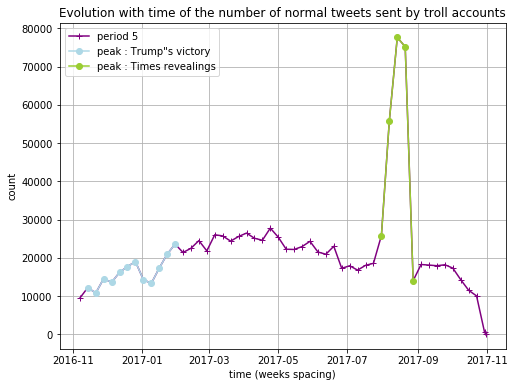

In [182]:
plt.figure(figsize=(8,6))

# /!\ occured the 8th of November 2016 => we keep counts even for January 2017 since the investiture occurs in 2017 and 
# the transition time between the efficient transfer power was a really 'hectic' time
peak_victory = normal_dates_w_p5_pd[(normal_dates_w_p5_pd.time>="2016-11-08") & (normal_dates_w_p5_pd.time<="2017-01-31")]

# /!\ Times' revealings
peak_gate = normal_dates_w_p5_pd[(normal_dates_w_p5_pd.time>="2017-07-25") & (normal_dates_w_p5_pd.time<="2017-08-31")]

plt.plot(normal_dates_w_p5_pd["time"],normal_dates_w_p5_pd["count"],color="purple",marker='+')
plt.plot(peak_victory["time"],peak_victory["count"],color="lightblue",marker='o')
plt.plot(peak_gate["time"],peak_gate["count"],color="yellowgreen",marker='o')
plt.title('Evolution with time of the number of normal tweets sent by troll accounts')
plt.grid()
plt.xlabel('time (weeks spacing)')
plt.ylabel('count')
plt.legend(['period 5','peak : Trump"s victory','peak : Times revealings'],loc=2);

On this graph, *Trump's* win for US2016 elections isn't noticeable : one more time this supports the thesis for which IRA troll farm isn't only focusing on the american elections : there's so much more at stake ! Again '*war*' in Ukrain is still undergoing in the background and that's why the troll tweets volume seem to be rather stable despite the victory of Trump. We discuss the huge peak of July 2017 below ! 

In [183]:
# get texts of the normal tweets corresponding to period 5
normal_tweets_texts_p5_query = """ SELECT normal_tweets_p5_sql.tweetid,tweet_language,tweet_text,userid,tweet_time,like_count,retweet_count,hashtags,urls
                                   FROM tweets_text_sql JOIN normal_tweets_p5_sql ON tweets_text_sql.tweetid == normal_tweets_p5_sql.tweetid
                               """

normal_tweets_texts_p5_df = spark.sql(normal_tweets_texts_p5_query)


## Parquet transformation 

# @comment if Parquet already built
#normal_tweets_texts_p5_df.write.mode('overwrite').parquet("normal_tweets_texts_p5_df")

normal_tweets_texts_p5_df = spark.read.parquet("normal_tweets_texts_p5_df")

# replace/update previous Spark SQL temporary view
normal_tweets_texts_p5_df.createOrReplaceTempView("normal_tweets_texts_p5_sql")


In [184]:
political_normal_tweets_texts_p5_df = normal_tweets_texts_p5_df.rdd.filter(lambda x: any(word in x.tweet_text for word in stop_words_political))

# @comment if Parquet already built
#political_normal_tweets_texts_p5_df.toDF().write.mode('overwrite').parquet("political_tweets_texts_p5_df")

political_normal_tweets_texts_p5_df = spark.read.parquet("political_tweets_texts_p5_df")

In [185]:
political_normal_tweets_texts_p5_df.createOrReplaceTempView("political_normal_tweets_p5_sql")

# group and count by weeks (only the weeks of interest corresponding to the current time window) 
political_normal_dates_w_p5_query = """SELECT COUNT(tweetid) AS count,MAX(tweet_time) AS time 
                                       FROM political_normal_tweets_p5_sql 
                                       GROUP BY CAST(DATEDIFF(tweet_time,"2016-10-31")/7 AS int)
                                       ORDER BY time ASC
                                    """
political_normal_dates_w_p5_df = spark.sql(political_normal_dates_w_p5_query)

# store as a Panda dataframe (very small, absolutely no problem with the memory)
political_normal_dates_w_p5_pd = political_normal_dates_w_p5_df.toPandas()

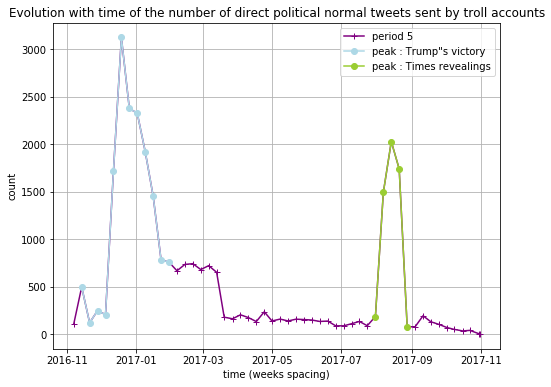

In [186]:
plt.figure(figsize=(8,6))

# /!\ occured the 8th of November 2016 => we keep counts even for January 2017 since the investiture occurs in 2017 and 
# the transition time between the efficient transfer power was a really 'hectic' time
peak_victory = political_normal_dates_w_p5_pd[(political_normal_dates_w_p5_pd.time>="2016-11-08") & (political_normal_dates_w_p5_pd.time<="2017-01-31")]

# /!\ Times' revealings
peak_gate = political_normal_dates_w_p5_pd[(political_normal_dates_w_p5_pd.time>="2017-07-25") & (political_normal_dates_w_p5_pd.time<="2017-08-31")]

plt.plot(political_normal_dates_w_p5_pd["time"],political_normal_dates_w_p5_pd["count"],color="purple",marker='+')
plt.plot(peak_victory["time"],peak_victory["count"],color="lightblue",marker='o')
plt.plot(peak_gate["time"],peak_gate["count"],color="yellowgreen",marker='o')
plt.title('Evolution with time of the number of direct political normal tweets sent by troll accounts')
plt.grid()
plt.xlabel('time (weeks spacing)')
plt.ylabel('count')
plt.legend(['period 5','peak : Trump"s victory','peak : Times revealings'],loc=1);

In order to be sure what for the second peak stands for we investigate its content : 

In [94]:
# group and count by weeks (only the weeks of interest corresponding to the current time window) 
political_normal_event_p5_query = """ SELECT * 
                                       FROM political_normal_tweets_p5_sql 
                                       WHERE tweet_time>="2017-07-25" AND tweet_time<="2017-08-20"
                                       ORDER BY retweet_count DESC
                                       LIMIT 10 
                                    """
political_normal_event_p5_df = spark.sql(political_normal_event_p5_query)

# store as a Panda dataframe (very small, absolutely no problem with the memory)
political_normal_event_p5_pd = political_normal_event_p5_df.toPandas()

In [95]:
# print troll tweet_texts (not all relevant)
for elem in political_normal_event_p5_pd.tweet_text:
    print(elem)

JULIAN ASSANGE: I investigated both presidential candidates — Hillary was the only one with corrupt ties to Russia https://t.co/MVVPkLORTb
Acosta just asked Trump why he isn't taking more questions.  Trump:  I like real news, not fake news, and you are fake news.  Priceless! 😄 https://t.co/MBsUQS7Q8L
RT lowt3ch: Soros funded media matters is working with Facebook and Twitter to kill pro trump articles https://t.co/zwDCm4to59
President Trump calling Jim Acosta/CNN fake news is officially the best thing I've seen this week.  Cry baby Jim, cry!
Шериф с помощниками пытают задержанного (т.е. это даже не заключённый). Ашленд Сити, штат Теннесси, самая демократичная страна в мире https://t.co/Rah6Eohs8K
So CNN fired Jeffrey Lord for tweets but did nothing about Philip Mudd making threats against President trump on live TV? https://t.co/HZ6Tul09Bj
"""The problems that are facing our nation has no color. We want jobs. We want economic opportunities. We want closed borders""~ @brunelldonald http

Those tweets are reactions about that "*scandale*" earlier in 2017 about *Trump's* collaboration with Russia and his false statements on social medias. 

Looking at the global timeline of events during the campaign : around July 2017 8th, Times revealed (accused) *Trump* had been negociating with russian contacts in Trump's tower. It was proven 6 months later to be true but didn't fail to attract a lot of mediatic buzz. As the *tweet_texts* mention it there was also *Comey*'s gate (FBI former director) ! 

Trolls here are just using the most basic technique : ***bad faith*** ! 

The most retweeted tweets speak for themselves : 

        - Comey is a liar and shouldn't investigate about Trump's legitimacy. 
        - Hillary is the only one corrupted w/ russians. 
        - To Trump, journalist Acosta is "fake news" (it launched a new trend by the way)

## RETWEETS

Let us take a look at the retweets: what was retweeted by and from the trolls, and by who. We are going to take a look at the numbers, and to build a graph with the interesting relationships.

### Build dataframes

In [31]:
retweets_df.createOrReplaceTempView("retweets_sql")

#### Retweets and count

We first count the number of posts that *userid* retweeted from *retweet_userid*.

In [32]:
retweets_edges_df = spark.sql("SELECT userid, retweet_userid, COUNT(*) AS count FROM retweets_sql GROUP BY userid, retweet_userid ORDER BY count DESC")
retweets_edges_df.createOrReplaceTempView("retweets_edges_sql")
print(retweets_edges_df.count(), len(retweets_edges_df.columns))
retweets_edges_df.show(5)

844950 3
+--------------------+--------------+-----+
|              userid|retweet_userid|count|
+--------------------+--------------+-----+
|a95a911dd6ae864c4...|    2746979823| 9875|
|a95a911dd6ae864c4...|       1367531| 2840|
|a95a911dd6ae864c4...|      25073877| 2498|
|74ceb7c6a46a5beb0...|    2577412818| 1743|
|          4859142199|    3312143142| 1624|
+--------------------+--------------+-----+
only showing top 5 rows



#### Outdegree

We are now interested in knowing how many retweets each troll performed (outdegree of the retweets graph).

In [33]:
retweets_outdegree_df = spark.sql("SELECT userid, SUM(count) AS outdegree FROM retweets_edges_sql GROUP BY userid ORDER BY outdegree DESC")
retweets_outdegree_df.createOrReplaceTempView("retweets_outdegree_sql")
print(retweets_outdegree_df.count(), len(retweets_outdegree_df.columns))
retweets_outdegree_df.show(5)

2975 2
+--------------------+---------+
|              userid|outdegree|
+--------------------+---------+
|a95a911dd6ae864c4...|   128897|
|cfb0d237487ebe352...|    36894|
|          3438999494|    26973|
|396b0b6914e425ca5...|    17980|
|0994abf9fb8fe1bf6...|    16960|
+--------------------+---------+
only showing top 5 rows



In [34]:
retweets_outdegree_df.describe().show()

+-------+--------------------+------------------+
|summary|              userid|         outdegree|
+-------+--------------------+------------------+
|  count|                2975|              2975|
|   mean|1.119043723887934...|1120.3979831932772|
| stddev|2.821889341538021...| 3093.046668622982|
|    min|004c1875a5f3a8ddf...|                 1|
|    max|ffe3cd0f54e1859e0...|            128897|
+-------+--------------------+------------------+



#### Indegree

We do the same for the indegree of the retweets graph.

In [35]:
retweets_indegree_df = spark.sql("SELECT retweet_userid, SUM(count) AS indegree FROM retweets_edges_sql GROUP BY retweet_userid ORDER BY indegree DESC")
retweets_indegree_df.createOrReplaceTempView("retweets_indegree_sql")
print(retweets_indegree_df.count(), len(retweets_indegree_df.columns))
retweets_indegree_df.show(5)

204289 2
+--------------+--------+
|retweet_userid|indegree|
+--------------+--------+
|      34200559|  123830|
|      32421706|   79030|
|    2570574680|   70395|
|     338960856|   67521|
|      72525490|   50560|
+--------------+--------+
only showing top 5 rows



#### Reduction

The graph is way too big to be manipulated. We reduce it to keep only the nodes that have either retweeted at least once or been retweeted more than 10 times.

In [36]:
retweets_indegree_small_df = spark.sql("SELECT * FROM retweets_indegree_sql WHERE indegree>10")
print(retweets_indegree_small_df.count())

16108


In [37]:
retweets_edges_small_df = retweets_edges_df.join(retweets_indegree_small_df, ['retweet_userid'])
retweets_edges_small_df = retweets_edges_small_df.join(retweets_outdegree_df, ['userid'])
print(retweets_edges_small_df.count())

533060


In [38]:
retweets_edges_small_df.describe().show()

+-------+--------------------+--------------------+------------------+------------------+------------------+
|summary|              userid|      retweet_userid|             count|          indegree|         outdegree|
+-------+--------------------+--------------------+------------------+------------------+------------------+
|  count|              533060|              533060|            533060|            533060|            533060|
|   mean|2.092886738435057...|3.062322930562337...|  5.58824334971673|2023.8185288710465| 4593.699915581736|
| stddev|1.318995774897990...|1.493328410978443...|25.572339631075646| 7701.910473550255|10463.071323139386|
|    min|004c1875a5f3a8ddf...|004c1875a5f3a8ddf...|                 1|                11|                 1|
|    max|ffe3cd0f54e1859e0...|ffe3cd0f54e1859e0...|              9875|            123830|            128897|
+-------+--------------------+--------------------+------------------+------------------+------------------+



In [39]:
retweets_edges_small_pd = retweets_edges_small_df.toPandas()

### Exposed users

To furthermore reduce our graph, we will now focus on users that are not anonymized. We consider them more interesting because we can obtain more information about them and because they were by definition more popular than anonymized accounts.

#### Exposed source

In [40]:
retweets_edges_small_df.createOrReplaceTempView("retweets_edges_small_sql")
exposed_user_df.createOrReplaceTempView("exposed_user_sql")
retweets_exposed_out = retweets_edges_small_df.join(exposed_user_df, ['userid'])
retweets_exposed_out.createOrReplaceTempView("retweets_exposed_out_sql")
retweets_exposed_out_df = spark.sql("SELECT userid, user_display_name, user_screen_name, retweet_userid, account_language, count, indegree, outdegree FROM retweets_exposed_out_sql")
retweets_exposed_out_pd = retweets_exposed_out_df.toPandas()

In [41]:
print(retweets_exposed_out_pd.shape)
retweets_exposed_out_pd.head()

(32804, 8)


,userid,user_display_name,user_screen_name,retweet_userid,account_language,count,indegree,outdegree
0,1240007161,Замполит,ComradZampolit,143469704,und,3,25,6323
1,1240007161,Замполит,ComradZampolit,1715286739,und,2,243,6323
2,1240007161,Замполит,ComradZampolit,219653959,und,3,65,6323
3,1240007161,Замполит,ComradZampolit,2302557678,und,2,31,6323
4,1240007161,Замполит,ComradZampolit,3039501256,und,1,20,6323


#### Exposed destination

In [42]:
retweets_exposed_in = retweets_edges_small_df.join(exposed_user_df.withColumnRenamed('userid', 'retweet_userid'), ['retweet_userid'])
retweets_exposed_in.createOrReplaceTempView("retweets_exposed_in_sql")
retweets_exposed_in_df = spark.sql("SELECT userid, user_display_name AS retweet_user_display_name, user_screen_name AS retweet_user_screen_name, retweet_userid, account_language AS rt_account_language, count AS rt_count, indegree AS rt_indegree, outdegree AS rt_outdegree FROM retweets_exposed_in_sql")
retweets_exposed_in_pd = retweets_exposed_in_df.toPandas()

In [43]:
print(retweets_exposed_in_pd.shape)
retweets_exposed_in_pd.head()

(32605, 8)


,userid,retweet_user_display_name,retweet_user_screen_name,retweet_userid,rt_account_language,rt_count,rt_indegree,rt_outdegree
0,202c8708b3ed415e943eade0a8e5bfb0ce7ceaf93fcc46...,Замполит,ComradZampolit,1240007161,und,19,14831,6111
1,202c8708b3ed415e943eade0a8e5bfb0ce7ceaf93fcc46...,Вестник России,vestnikrus,2481527106,ru,29,15544,6111
2,202c8708b3ed415e943eade0a8e5bfb0ce7ceaf93fcc46...,Открытая Россия,ruopentwit,2572896396,ru,25,17841,6111
3,202c8708b3ed415e943eade0a8e5bfb0ce7ceaf93fcc46...,Викулова Татьяна,sinigopajuby,2256210373,en,3,672,6111
4,202c8708b3ed415e943eade0a8e5bfb0ce7ceaf93fcc46...,Вестник Петербурга,NovostiSPb,508761973,en,35,22366,6111


#### Join both

In [44]:
retweets_exposed_df = retweets_exposed_out_df.join(retweets_exposed_in_df, ['userid', 'retweet_userid'])
retweets_exposed_pd = retweets_exposed_df.toPandas()
print(retweets_exposed_pd.shape)
retweets_exposed_pd.head()

(1145, 14)


,userid,retweet_userid,user_display_name,user_screen_name,account_language,count,indegree,outdegree,retweet_user_display_name,retweet_user_screen_name,rt_account_language,rt_count,rt_indegree,rt_outdegree
0,1240007161,2526297190,Замполит,ComradZampolit,und,9,14,6323,АгитПолк,AgitPolk,ru,9,14,6323
1,2532611755,2882013788,Kathie,KathieMrr,en,105,6082,3433,Giselle Evans,GiselleEvns,en,105,6082,3433
2,2721995401,2808833544,Мария Можайская,MaryMozhaiskaya,en,9,19753,296,Максим Дементьев,MaxDementiev,ru,9,19753,296
3,3049228218,3806028575,Вестник Луганска,LuganskNovosti,ru,1,214,213,Вестник Тулы,VestnikTula,ru,1,214,213
4,508761973,2808833544,Вестник Петербурга,NovostiSPb,en,11,19753,1930,Максим Дементьев,MaxDementiev,ru,11,19753,1930


#### Initialize graph

In [45]:
retweet_exposed_graph = nx.from_pandas_edgelist(retweets_exposed_pd, 'userid', 'retweet_userid', edge_attr='count', create_using= nx.DiGraph())

#### Node attributes
We define several node attributes that can be useful for later visualisation: indegree, outdegree and degree (sum of in and out) ; display and screen name ; account language.

In [46]:
dict_indeg = dict(zip(retweets_exposed_pd.retweet_userid, retweets_exposed_pd.indegree))
dict_outdeg = dict(zip(retweets_exposed_pd.userid, retweets_exposed_pd.outdegree))
dict_display = dict(zip(retweets_exposed_pd.retweet_userid, retweets_exposed_pd.retweet_user_display_name))
dict_display.update(dict(zip(retweets_exposed_pd.userid, retweets_exposed_pd.user_display_name)))
dict_screen = dict(zip(retweets_exposed_pd.retweet_userid, retweets_exposed_pd.retweet_user_screen_name))
dict_screen.update(dict(zip(retweets_exposed_pd.userid, retweets_exposed_pd.user_screen_name)))
dict_lang = dict(zip(retweets_exposed_pd.retweet_userid, retweets_exposed_pd.rt_account_language))
dict_lang.update(dict(zip(retweets_exposed_pd.userid, retweets_exposed_pd.account_language)))

nx.set_node_attributes(retweet_exposed_graph, dict_indeg, name="indegree")
nx.set_node_attributes(retweet_exposed_graph, dict_outdeg, name="outdegree")
nx.set_node_attributes(retweet_exposed_graph, dict_display, name="display")
nx.set_node_attributes(retweet_exposed_graph, dict_screen, name="screen")
nx.set_node_attributes(retweet_exposed_graph, dict_lang, name="lang")

In [47]:
print(len(dict_indeg))
print(len(dict_outdeg))
print(len(dict_display))
print(len(dict_screen))
print(len(dict_lang))
print(nx.info(retweet_exposed_graph))

122
108
137
137
137
Name: 
Type: DiGraph
Number of nodes: 137
Number of edges: 1145
Average in degree:   8.3577
Average out degree:   8.3577


#### Write graph
We finally save the graph as a *gexf* file that can be used with *Gephi*.g

In [48]:
nx.write_gexf(retweet_exposed_graph, "retweet_exposed_graph.gexf")

### Observations

Let us now dig deeper and look more precisely into the details of our data.

#### Main retweeters
We first observe the exposed trolls that performed the most retweets.

In [49]:
most_rt_out = retweets_outdegree_df.join(exposed_user_df.select('userid', 'user_screen_name', 'user_display_name', 'account_language'), ['userid']).limit(20).toPandas()
colors = []
for l in most_rt_out['account_language']:
    if l=='en':
        colors.append('blue')
    else:
        colors.append('red')

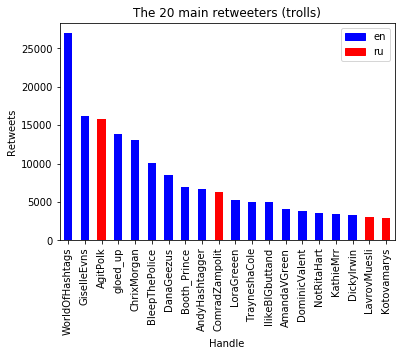

In [50]:
most_rt_out.head(20).plot.bar(x = "user_screen_name", y = "outdegree",legend=True, title="The 20 main retweeters (trolls)",grid=False, color = colors);
blue_patch = mpatches.Patch(color='blue', label='en')
red_patch = mpatches.Patch(color='red', label='ru')
plt.legend(handles=[blue_patch, red_patch])
plt.xlabel('Handle')
plt.ylabel('Retweets')
plt.savefig('retweeter_trolls.png', bbox_inches='tight', dpi=200, transparent=True)

#### Most retweeted
We look at the exposed accounts (non-trolls and trolls) that were the most retweeted by the trolls.

In [52]:
most_retweeted = retweets_indegree_df.limit(20).toPandas()

In [53]:
for index, row in most_retweeted.iterrows():
    if len(row['retweet_userid'])>10:
        most_retweeted.at[index, 'retweet_userid'] = (row['retweet_userid'])[:10]+"..."

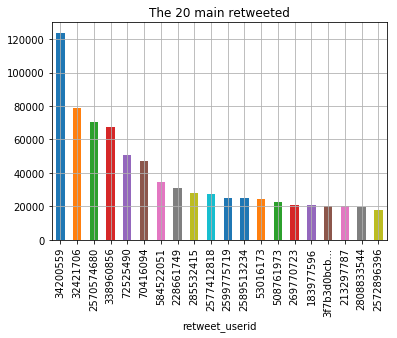

In [54]:
most_retweeted.plot.bar(x = "retweet_userid", y = "indegree",legend=False, title="The 20 main retweeted",grid=True);

Thanks to [tweeterid](https://tweeterid.com), we can easily identify the accounts that are not in our database. Note that some of them have been deleted.

In [55]:
userid_to_screen = ['rianru', 'GazetaRu', '', 'RT_russian', 'vesti_news', '', 'Pravdiva_pravda', 'lentaruofficial', 
                    'tass_agency', 'leprasorium', '', '', 'lifenews_ru', '', 'ru_rbc', 'champ_football', '[ANON]', 'izvestia_ru', '', '']

In [56]:
for i in range(0,len(userid_to_screen)):
    if userid_to_screen[i]=='':
        temp_req = spark.sql("SELECT user_screen_name FROM exposed_user_sql WHERE userid="+ most_retweeted.retweet_userid[i])
        if temp_req.count()>0:
            userid_to_screen[i] = temp_req.toPandas().user_screen_name[0]
        else:
            userid_to_screen[i] = '[DELETED]'

In [57]:
most_retweeted['user_screen_name'] = userid_to_screen

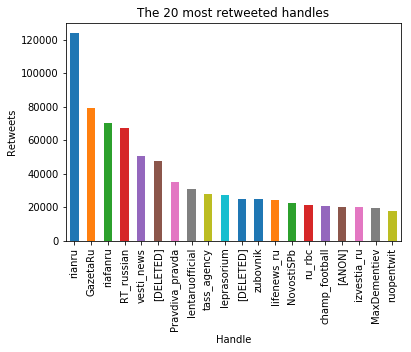

In [58]:
most_retweeted.plot.bar(x = "user_screen_name", y = "indegree",legend=False, title="The 20 most retweeted handles",grid=False)

plt.xlabel('Handle')
plt.ylabel('Retweets')
plt.savefig('retweeted_all.png', bbox_inches='tight', dpi=200, transparent=True)

We do the same but focused on the exposed trolls.

In [61]:
most_rt_in = retweets_indegree_df.withColumnRenamed('retweet_userid','userid').join(exposed_user_df.select('userid', 'user_screen_name', 'user_display_name', 'account_language'), ['userid']).toPandas()

In [62]:
colors = []
for l in most_rt_in['account_language'].head(20):
    if l=='en':
        colors.append('blue')
    else:
        colors.append('red')

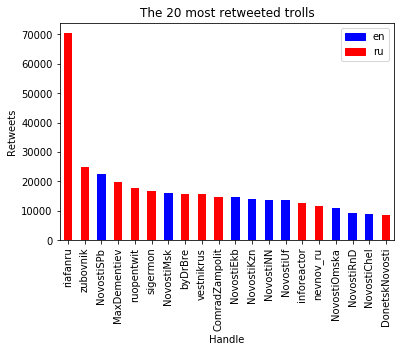

In [63]:
most_rt_in.head(20).plot.bar(x = "user_screen_name", y = "indegree",legend=False, title="The 20 most retweeted trolls",grid=False, color=colors);
blue_patch = mpatches.Patch(color='blue', label='en')
red_patch = mpatches.Patch(color='red', label='ru')
plt.legend(handles=[blue_patch, red_patch])
plt.xlabel('Handle')
plt.ylabel('Retweets')
plt.savefig('retweeted_trolls.png', bbox_inches='tight', dpi=200, transparent=True)

### Languages
Let us now see how Russian and English are distributed among the retweets.

In [65]:
retweets_lang_df = tweets_text_df['tweetid', 'tweet_language'].join(retweets_df.select(['tweetid']), ['tweetid'])
retweeted_lang_df = tweets_text_df['tweetid', 'tweet_language'].join((normal_tweets_df.select(['tweetid', 'retweet_count'])).union(replies_df.select(['tweetid', 'retweet_count'])), ['tweetid'])
retweets_lang_df.createOrReplaceTempView("retweets_lang_sql")
retweeted_lang_df.createOrReplaceTempView("retweeted_lang_sql")

In [66]:
retweets_lang_count = spark.sql("SELECT tweet_language, COUNT(*) AS count FROM retweets_lang_sql GROUP BY tweet_language ORDER BY count DESC")
retweeted_lang_count = spark.sql("SELECT tweet_language, SUM(retweet_count) AS count FROM retweeted_lang_sql GROUP BY tweet_language ORDER BY count DESC")

In [67]:
retweets_lang_count_pd = retweets_lang_count.toPandas()
retweeted_lang_count_pd = retweeted_lang_count.toPandas()

In [68]:
print(retweets_lang_count_pd.shape)
print(retweeted_lang_count_pd.shape)

(52, 2)
(56, 2)


#### Languages retweeted by the trolls

In [69]:
retweets_lang_count_pd.head(10)

,tweet_language,count
0,ru,2013563
1,en,1083622
2,und,122182
3,uk,32348
4,bg,18114
5,it,17883
6,de,13073
7,fr,5135
8,es,4400
9,in,2782


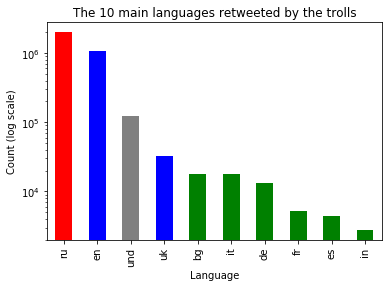

In [70]:
colors = ['red', 'blue', 'grey', 'blue']
colors.extend(['green']*(10-len(colors)))
retweets_lang_count_pd.head(10).plot.bar(x = "tweet_language", y = "count",legend=False, title="The 10 main languages retweeted by the trolls",grid=False, color=colors)
plt.yscale('log')
plt.xlabel('Language')
plt.ylabel('Count (log scale)')
plt.savefig('retweets_lang.png', bbox_inches='tight', dpi=200, transparent=True)

#### Languages in posts from the trolls that were retweeted

In [71]:
retweeted_lang_count_pd.head(10)

,tweet_language,count
0,en,21913266
1,ru,8530216
2,und,537911
3,uk,86902
4,de,74693
5,bg,48344
6,fr,7201
7,sr,6984
8,in,6590
9,ar,6579


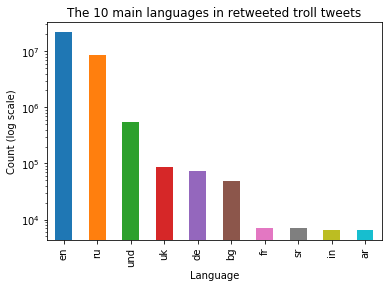

In [72]:
retweeted_lang_count_pd.head(10).plot.bar(x = "tweet_language", y = "count",legend=False, title="The 10 main languages in retweeted troll tweets",grid=False)
plt.yscale('log')
plt.xlabel('Language')
plt.ylabel('Count (log scale)')
plt.savefig('retweets_lang.png', bbox_inches='tight', dpi=200, transparent=True)

## URLs in Tweets

We now take a closer look at the urls that can be found in the troll tweets.
We first need to gather all those urls, and sort them by language.

In [31]:
tweets_stats_df['tweetid','urls'].createOrReplaceTempView("urls_sql")
urls_df = spark.sql("SELECT tweetid, urls FROM urls_sql WHERE urls IS NOT NULL AND NOT urls='[]'")

In [32]:
tweets_url_lang_df = urls_df.join(tweets_text_df.select('tweetid', 'tweet_language'), ['tweetid'])
tweets_url_lang_df.createOrReplaceTempView("tweets_url_lang_sql")
tweets_url_en_df = spark.sql("SELECT urls FROM tweets_url_lang_sql WHERE tweet_language='en'")
tweets_url_ru_df = spark.sql("SELECT urls FROM tweets_url_lang_sql WHERE tweet_language='ru'")
tweets_url_other_df = spark.sql("SELECT urls FROM tweets_url_lang_sql WHERE NOT (tweet_language='en' OR tweet_language='ru')")

In [33]:
print(tweets_url_lang_df.count())
print(tweets_url_en_df.count())
print(tweets_url_ru_df.count())
print(tweets_url_other_df.count())

4590337
1142115
3032919
415303


In [34]:
def parse_url(url_df):
    urls_array_list = []
    for r in url_df.select('urls').collect():
            urls_array_list.append((r['urls'])[1:-1].split(", "))
    urls_list = [item for sublist in urls_array_list for item in sublist]
    return urls_list

In [35]:
en_urls_list = parse_url(tweets_url_en_df)
ru_urls_list = parse_url(tweets_url_ru_df)
other_urls_list = parse_url(tweets_url_other_df)
print(len(en_urls_list), len(ru_urls_list), len(other_urls_list))

1169882 3039821 425974


In [36]:
def build_url_df(urls_list):
    all_urls = {}
    for u in urls_list:
        if u in all_urls:
            all_urls[u] += 1
        else:
            all_urls[u] = 1
    sorted_urls = sorted(all_urls, key=all_urls.get, reverse=True)
    urls_df = pd.DataFrame()
    urls_df['url'] = sorted_urls
    urls_df['count'] = urls_df['url'].map(lambda x: all_urls[x])
    return urls_df

In [37]:
en_urls_pd = build_url_df(en_urls_list)
ru_urls_pd = build_url_df(ru_urls_list)
other_urls_pd = build_url_df(other_urls_list)

In [38]:
all_urls_pd = en_urls_pd.set_index('url').join(ru_urls_pd.set_index('url'), how="outer", lsuffix='_en', rsuffix='_ru')
all_urls_pd = all_urls_pd.join((other_urls_pd.set_index('url')).rename({'count':'count_other'}, axis='columns'), how="outer")
all_urls_pd.fillna(0, inplace=True)
all_urls_pd['count'] = (all_urls_pd['count_other']+all_urls_pd['count_en']+all_urls_pd['count_ru']).astype(int)

In [39]:
all_urls_pd.sort_values('count', inplace=True, ascending=False)
all_urls_pd.head(10)

,count_en,count_ru,count_other,count
url,,,,
http://1063.mobi,4357.0,0.0,71.0,4428
http://USFREEDOMARMY.COM,3662.0,0.0,0.0,3662
http://kiev-news.com/13876-detskaya-bolnica-v-donecke-popala-pod-obstrel.html,0.0,2867.0,0.0,2867
http://kievsmi.net/novosti/politics/47097-klimkin-peregovory-ukrainy-i-rossii-idut-neprosto.html,0.0,2800.0,1.0,2801
http://bit.ly/1D3LvAc,2369.0,0.0,0.0,2369
http://kiev-news.com/13872-v-kieve-shkolnikov-uchat-kak-vesti-sebya-pri-zaminirovanii.html,0.0,2178.0,0.0,2178
http://Covfefe.bz,2035.0,0.0,19.0,2054
https://twibble.io,1719.0,136.0,34.0,1889
http://www.theunder.us,1255.0,0.0,62.0,1317


In [40]:
all_urls_pd.describe()

,count_en,count_ru,count_other,count
count,2.776243e+06,2.776243e+06,2.776243e+06,2.776243e+06
mean,4.213903e-01,1.094941e+00,1.534354e-01,1.669766e+00
std,5.021726e+00,4.522232e+00,1.192444e+00,6.886708e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
50%,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00
75%,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00
max,4.357000e+03,2.867000e+03,8.840000e+02,4.428000e+03


In [41]:
all_urls_pd.sort_values('count_en', inplace=False, ascending=False).head(10)

,count_en,count_ru,count_other,count
url,,,,
http://1063.mobi,4357.0,0.0,71.0,4428
http://USFREEDOMARMY.COM,3662.0,0.0,0.0,3662
http://bit.ly/1D3LvAc,2369.0,0.0,0.0,2369
http://Covfefe.bz,2035.0,0.0,19.0,2054
https://twibble.io,1719.0,136.0,34.0,1889
http://www.theunder.us,1255.0,0.0,62.0,1317
http://payday-loans-24.com/,1203.0,0.0,0.0,1203
http://rdo.to/WKMTDB,835.0,0.0,298.0,1133
http://ireport.cnn.com/docs/DOC-1201697,799.0,0.0,5.0,804


From the statistics obtained thanks to *describe*, we can see that the vast majority of urls only appear once. But some of them seem strangely popular. Those are mostly domain names, and not specific pages. In the top 10 for the most popular urls in English tweet we find:

* **http://USFREEDOMARMY.COM**, **http://Covfefe.bz**, **https://www.telegraph.co.uk**: those three are linked to American politics. The first one is a right-wing fake news website. The second one gets its name from a famous Trump tweet. The last one is a British newspaper which has a notable conservative stance and  which has been [accused of spreading pro-Russian propaganda](https://en.wikipedia.org/wiki/The_Daily_Telegraph#Accusation_of_news_coverage_influence_by_advertisers).
(**NB**: *http://bit.ly/1D3LvAc* is a shortened url for *https://www.telegraph.co.uk*.)

* Several (supposedly) Ukrainian articles written in Russian.

* **https://twibble.io**: a social media manager.

* **http://1063.mobi**, **http://www.theunder.us**: two indie web radios.

We were intrigued by *http://1063.mobi* and its particularly high count, so we decided to investigate further. The url redirects to *http://1063atl.com*, an Atlanta based indie web radio. As this is not exactly the same url, we wanted to make sure that *1063atl.com* is effectively the new name of *1063.mobi*, and not something completely different.

Using the [Wayback Machine](http://web.archive.org), we are able to take a look at the website before the redirection existed. [This](http://web.archive.org/web/20180110013854/http://1063.mobi:80/) shows us that the page was indeed very similar to the current *http://1063atl.com*.

We are also interested in knowing the context in which this url was used.

In [42]:
urls_1063mobi_df = spark.sql("SELECT tweetid, urls FROM urls_sql WHERE urls LIKE '%http://1063.mobi%'")
tweets_text_df.createOrReplaceTempView("tweets_text_sql")
text_1063mobi_df = spark.sql("SELECT tweet_text FROM tweets_text_sql T, urls_sql U WHERE urls LIKE '%http://1063.mobi%' AND T.tweetid=U.tweetid")

In [43]:
for x in (text_1063mobi_df.select('tweet_text').toPandas())['tweet_text'][10:20]:
    print(x)

RT @IndieRadioPlay: Now Playing: ManMan Savage - Psycho  Ft. Lil Uzi Vert -&gt; https://t.co/eMX9JgTv3v
RT @IndieRadioPlay: Now Playing: RickStarr (@SlickRickstarr) - Hit Me Up Feat Doe B -&gt; https://t.co/eMX9JgTv3v
RT @IndieRadioPlay: Now Playing: RickStarr (@SlickRickstarr) - I Got That -&gt; https://t.co/eMX9JgTv3v
RT @IndieRadioPlay: Now Playing: 1063 Drop (Atlanta, GA) - Beat After Beat -&gt; https://t.co/eMX9JgTv3v
RT @IndieRadioPlay: Now Playing: Shadetree K-Dee ft RickStarr - Satellite Pimpn  (@shadetreekdee) -&gt; https://t.co/eMX9JgTv3v
RT @1063atl: Now Playing: Shadetree K-Dee (@shadetreekdee) ft RickStarr - Satellite Pimpn -&gt; https://t.co/eMX9JgTv3v
RT @1063atl: Now Playing: Gucci Mane - Die A Gangsta Ft. Future -&gt; https://t.co/eMX9JgTv3v
RT @1063atl: Now Playing: Adam Swoosh (@adamswoosh01) - Immortal ft. Roam Bad Daddy -&gt; https://t.co/eMX9JgTv3v
RT @1063atl: Now Playing: Famous Dex - Jump -&gt; https://t.co/eMX9JgTv3v
RT @1063atl: Now Playing: 106.3 Mobile Radi

All those tweets seem mostly inoffensive, although they could be considered as spam. But they are all directed towards two Twitter handles: **@IndieRadioPlay** and **@1063atl**.
A quick look on Twitter shows us that **@IndieRadioPlay** does not exist anymore. Once again, with the Wayback Machine, we can get an idea of [what the page looked like](http://web.archive.org/web/20150822213646/https://twitter.com/indieradioplay). 

This account has the same banner and the same creation date as the [current Twitter page](https://twitter.com/1063atl?lang=fr) *@1063atl*. We can thus suppose that they are the same.

It is interesting to see that the most used url does not seem to be related to politics at all. Further investigations are necessary to understand why: is it an attempt to look like a normal user and/or to boost a troll account's statistics/popularity? Is there a reason for this radio to be targetted by the trolls or are they completely unrelated (outside of those tweets)?

#### Popular domains
After looking at specific urls, we observe the most popular domain names, and compare their popularities with respect to the language of the tweets.

In [44]:
domains = []
for index, row in all_urls_pd.iterrows():
    domains.append(urlparse(index).netloc)
all_urls_pd['domain'] = domains
all_domains_df = spark.createDataFrame(all_urls_pd)

In [45]:
all_domains_df.createOrReplaceTempView("all_domains_sql")
all_domains_count_df = spark.sql("SELECT domain, SUM(count_en) AS count_en, SUM(count_ru) AS count_ru, SUM(count_other) AS count_other, SUM(count) AS count FROM all_domains_sql GROUP BY domain ORDER BY count DESC")

In [46]:
all_domains_pd = all_domains_count_df.toPandas()
print(all_domains_pd.shape)
all_domains_pd['count_en'] = all_domains_pd['count_en'].astype(int)
all_domains_pd['count_ru'] = all_domains_pd['count_ru'].astype(int)
all_domains_pd['count_other'] = all_domains_pd['count_other'].astype(int)
all_domains_pd.head(20)

(34941, 5)


,domain,count_en,count_ru,count_other,count
0,bit.ly,109653,769083,96292,975028
1,riafan.ru,1,417754,11039,428794
2,twitter.com,155148,24408,46295,225851
3,ift.tt,114741,51692,2461,168894
4,goo.gl,29862,114791,11641,156294
5,dlvr.it,7413,130694,3580,141687
6,www.gazeta.ru,8,119564,3460,123032
7,j.mp,1533,94125,9887,105545
8,russian.rt.com,0,72015,1054,73069
9,youtu.be,28293,27618,5224,61135


As expected, there are much less unique domain names than urls. Again, most of them are used only once or twice. But some of them have a count that contrasts with the rest.

In the top 10 for English tweets, we have:
* **bit.ly**, **goo.gl**, **j.mp**: url shorteners, which are very practical for tweets since the number of characters is limited. Sadly, they do not teach us anything about their content: to know more about that, we need to open them and see where they redirect.
* **rufian.ru**, **gazeta.ru**, **russian.rt.com**: Russian news websites.
* **ift.tt**, **dlvr.it**: social media management systems.
* **youtu.be**: shorter url for Youtube.
* **twitter.com**: many urls on Twitter refer to the website itself. The shortener **t.co** is also very popular.

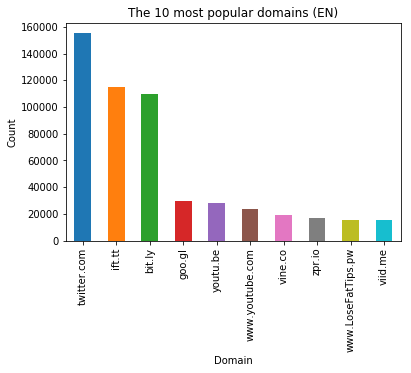

In [50]:
all_domains_pd.sort_values('count_en', inplace=True, ascending=False)
all_domains_pd.head(10).plot.bar(x = "domain", y = "count_en",legend=False, title="The 10 most popular domains (EN)",grid=False)
plt.xlabel('Domain')
plt.ylabel('Count')
plt.savefig('domains_en.png', bbox_inches='tight', dpi=200, transparent=True)

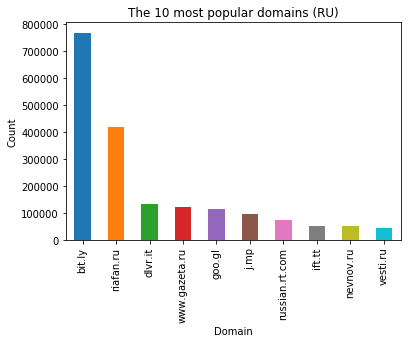

In [51]:
all_domains_pd.sort_values('count_ru', inplace=True, ascending=False)
all_domains_pd.head(10).plot.bar(x = "domain", y = "count_ru",legend=False, title="The 10 most popular domains (RU)",grid=False)
plt.xlabel('Domain')
plt.ylabel('Count')
plt.savefig('domains_en.png', bbox_inches='tight', dpi=200, transparent=True)

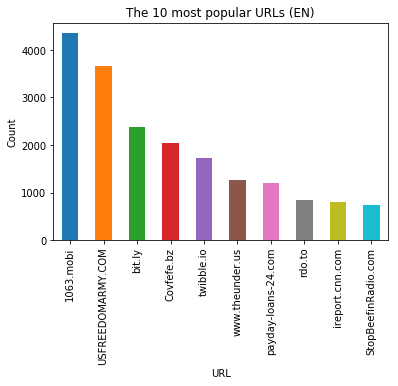

In [55]:
all_urls_pd.sort_values('count_en', inplace=True, ascending=False)
all_urls_pd.head(10).plot.bar(x = "domain", y = "count_en",legend=False, title="The 10 most popular URLs (EN)",grid=False)
plt.xlabel('URL')
plt.ylabel('Count')
plt.savefig('domains_en.png', bbox_inches='tight', dpi=200, transparent=True)

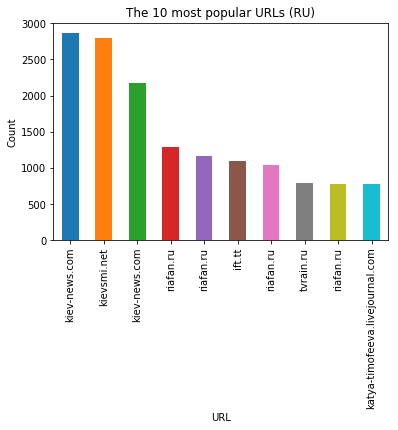

In [56]:
all_urls_pd.sort_values('count_ru', inplace=True, ascending=False)
all_urls_pd.head(10).plot.bar(x = "domain", y = "count_ru",legend=False, title="The 10 most popular URLs (RU)",grid=False)
plt.xlabel('URL')
plt.ylabel('Count')
plt.savefig('domains_en.png', bbox_inches='tight', dpi=200, transparent=True)

----------------------------------------------------------------------